In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from PIL import Image
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import zipfile

import torch.nn.functional as F
from rich.console import Console
from rich.progress import Progress, BarColumn, TimeElapsedColumn, TimeRemainingColumn
from rich.table import Table

import pandas as pd
from torch.cuda.amp import autocast, GradScaler


from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import numpy as np

In [2]:
# Install Git in case it's not available in your environment
!apt-get install git

# Clone the repository from GitHub
!git clone https://github.com/khairul-amin-cyber/CSE499-MerakiNexus-AI_And_Defi.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Cloning into 'CSE499-MerakiNexus-AI_And_Defi'...
remote: Enumerating objects: 8367, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8367 (delta 0), reused 2 (delta 0), pack-reused 8361 (from 1)
Receiving objects: 100% (8367/8367), 1.84 GiB | 45.66 MiB/s, done.
Resolving deltas: 100% (1250/1250), done.
Updating files: 100% (8654/8654), done.


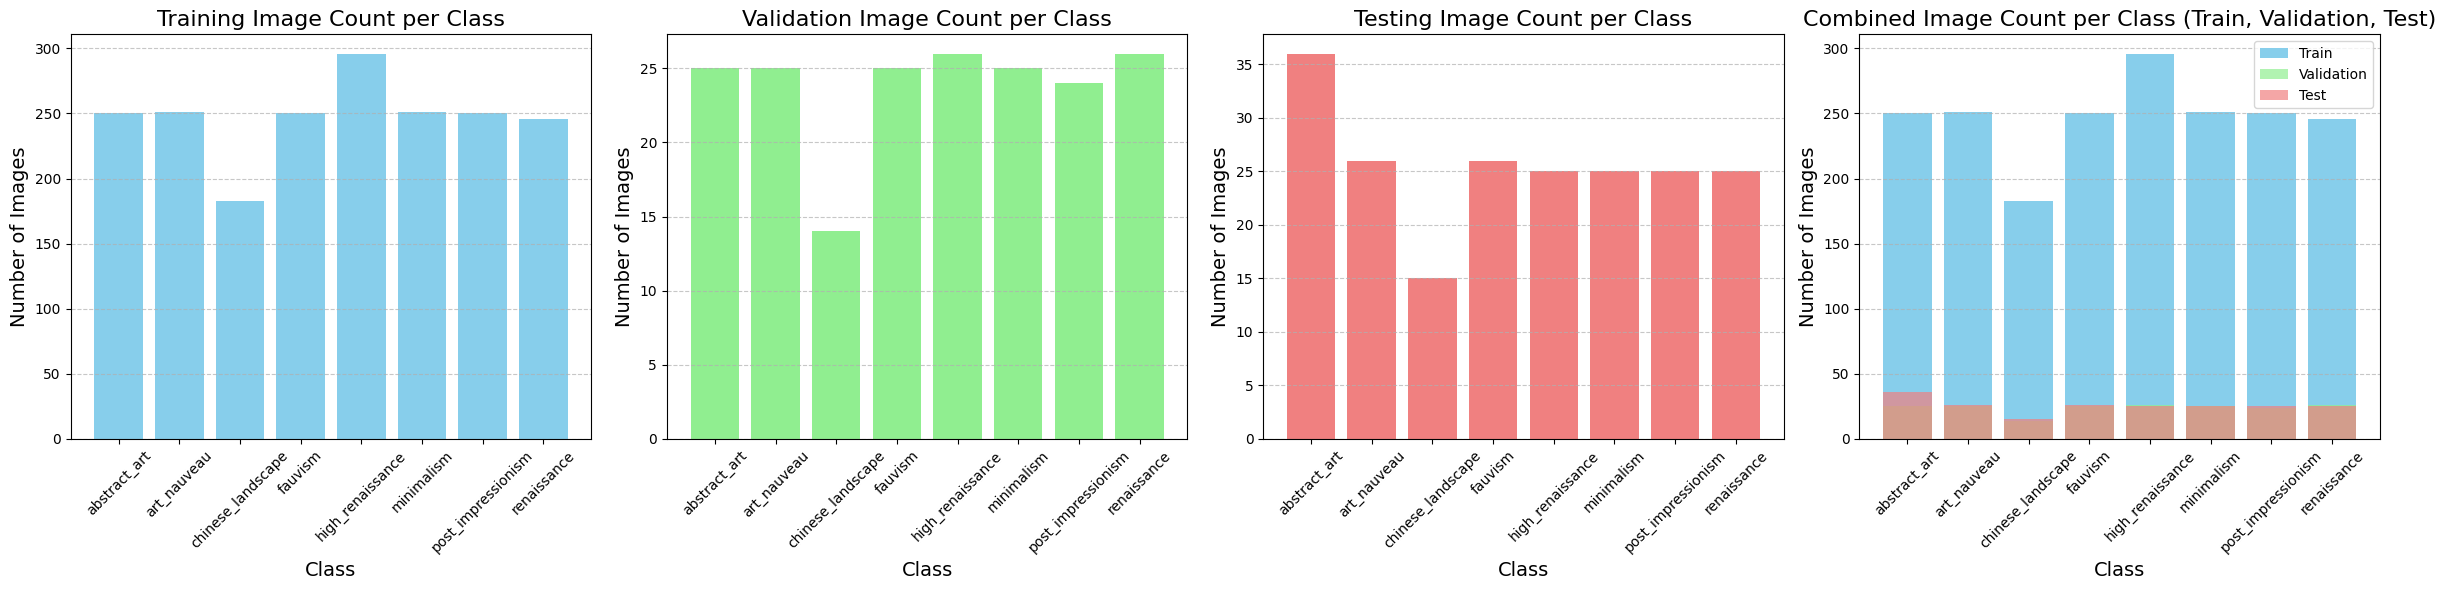

In [3]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets

# Define dataset path
dataset_path = "/content/CSE499-MerakiNexus-AI_And_Defi/aesthetic_model/aesthetic_dataset"  # Modify with your dataset path

# Load the datasets
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train")
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val")
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test")

# Get class names and their corresponding folder paths
class_names = train_dataset.classes
train_image_counts = []
val_image_counts = []
test_image_counts = []

# Count the number of images in each class folder for all datasets
for class_name in class_names:
    # Count for training set
    train_class_folder = os.path.join(train_dataset.root, class_name)
    train_image_count = len(os.listdir(train_class_folder))  # Count files in each class folder
    train_image_counts.append(train_image_count)

    # Count for validation set
    val_class_folder = os.path.join(val_dataset.root, class_name)
    val_image_count = len(os.listdir(val_class_folder))  # Count files in each class folder
    val_image_counts.append(val_image_count)

    # Count for testing set
    test_class_folder = os.path.join(test_dataset.root, class_name)
    test_image_count = len(os.listdir(test_class_folder))  # Count files in each class folder
    test_image_counts.append(test_image_count)

# Plotting the class distribution for training, validation, and testing sets side by side
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Plot for training dataset
axes[0].bar(class_names, train_image_counts, color='skyblue')
axes[0].set_title('Training Image Count per Class', fontsize=16)
axes[0].set_xlabel('Class', fontsize=14)
axes[0].set_ylabel('Number of Images', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for validation dataset
axes[1].bar(class_names, val_image_counts, color='lightgreen')
axes[1].set_title('Validation Image Count per Class', fontsize=16)
axes[1].set_xlabel('Class', fontsize=14)
axes[1].set_ylabel('Number of Images', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for testing dataset
axes[2].bar(class_names, test_image_counts, color='lightcoral')
axes[2].set_title('Testing Image Count per Class', fontsize=16)
axes[2].set_xlabel('Class', fontsize=14)
axes[2].set_ylabel('Number of Images', fontsize=14)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for combined view (Training, Validation, and Testing)
axes[3].bar(class_names, train_image_counts, color='skyblue', label='Train')
axes[3].bar(class_names, val_image_counts, color='lightgreen', label='Validation', alpha=0.7)
axes[3].bar(class_names, test_image_counts, color='lightcoral', label='Test', alpha=0.7)
axes[3].set_title('Combined Image Count per Class (Train, Validation, Test)', fontsize=16)
axes[3].set_xlabel('Class', fontsize=14)
axes[3].set_ylabel('Number of Images', fontsize=14)
axes[3].tick_params(axis='x', rotation=45)
axes[3].legend()
axes[3].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()


In [4]:
# Mapping of sub-classes to main aesthetic classes (binary labels for each class)
class_to_main_class = {
    "abstract_art": [1, 0, 0, 0],  # Balance
    "art_nauveau": [1, 0, 0, 0],   # Balance
    "chinese_landscape": [0, 0, 0, 1],  # Texture & Brushwork
    "fauvism": [0, 1, 0, 0],  # Color Harmony
    "high_renaissance": [0, 0, 1, 0],  # Depth & Perspective
    "minimalism": [0, 0, 0, 1],  # Texture & Brushwork
    "post_impressionism": [0, 0, 1, 0],  # Depth & Perspective
    "renaissance": [0, 1, 0, 0]  # Color Harmony
}

# Custom Dataset to handle multi-label classification
class CustomAestheticDataset(datasets.ImageFolder):
    def __init__(self, root_dir, transform=None):
        super().__init__(root_dir, transform=transform)
        self.class_to_main_class = class_to_main_class

    def __getitem__(self, idx):
        img_path, class_idx = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(self.class_to_main_class[self.classes[class_idx]], dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations for dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset_path = "/content/CSE499-MerakiNexus-AI_And_Defi/aesthetic_model/aesthetic_dataset"  # Modify with your dataset path

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data = CustomAestheticDataset(root_dir=f"{dataset_path}/train", transform=transform)
val_data = CustomAestheticDataset(root_dir=f"{dataset_path}/val", transform=transform)
test_data = CustomAestheticDataset(root_dir=f"{dataset_path}/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s]
Epoch 1/25 Training: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=1.27]


Epoch 1/25 completed in 42.40 seconds.
Epoch Loss: 1.4219489693641663
Train Accuracy: 83.82%


Epoch 1/25 Validation Accuracy: 84.79%


Epoch 2/25 Training: 100%|██████████| 62/62 [00:49<00:00,  1.25batch/s, loss=0.85]


Epoch 2/25 completed in 49.65 seconds.
Epoch Loss: 0.5199337106558585
Train Accuracy: 95.35%


Epoch 2/25 Validation Accuracy: 87.30%


Epoch 3/25 Training: 100%|██████████| 62/62 [00:43<00:00,  1.43batch/s, loss=0.258]


Epoch 3/25 completed in 43.29 seconds.
Epoch Loss: 0.24603322550894752
Train Accuracy: 97.86%


Epoch 3/25 Validation Accuracy: 89.02%


Epoch 4/25 Training: 100%|██████████| 62/62 [00:45<00:00,  1.36batch/s, loss=0.109]


Epoch 4/25 completed in 45.44 seconds.
Epoch Loss: 0.1974948825494897
Train Accuracy: 98.31%


Epoch 4/25 Validation Accuracy: 86.64%


Epoch 5/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.63batch/s, loss=0.0856]


Epoch 5/25 completed in 38.16 seconds.
Epoch Loss: 0.1708871845997149
Train Accuracy: 98.52%


Epoch 5/25 Validation Accuracy: 85.71%


Epoch 6/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.60batch/s, loss=0.196]


Epoch 6/25 completed in 38.83 seconds.
Epoch Loss: 0.15274666796528524
Train Accuracy: 98.73%


Epoch 6/25 Validation Accuracy: 87.30%


Epoch 7/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.61batch/s, loss=0.0486]


Epoch 7/25 completed in 38.53 seconds.
Epoch Loss: 0.11501658506571286
Train Accuracy: 99.10%


Epoch 7/25 Validation Accuracy: 87.43%


Epoch 8/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.60batch/s, loss=0.211]


Epoch 8/25 completed in 38.84 seconds.
Epoch Loss: 0.08153886015286609
Train Accuracy: 99.24%


Epoch 8/25 Validation Accuracy: 89.55%


Epoch 9/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.63batch/s, loss=0.402]


Epoch 9/25 completed in 38.08 seconds.
Epoch Loss: 0.06626577095143617
Train Accuracy: 99.51%


Epoch 9/25 Validation Accuracy: 89.81%


Epoch 10/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.62batch/s, loss=0.00414]


Epoch 10/25 completed in 38.23 seconds.
Epoch Loss: 0.1050821282495294
Train Accuracy: 99.02%


Epoch 10/25 Validation Accuracy: 88.23%


Epoch 11/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.62batch/s, loss=0.00414]


Epoch 11/25 completed in 38.32 seconds.
Epoch Loss: 0.10848710909035177
Train Accuracy: 99.05%


Epoch 11/25 Validation Accuracy: 86.90%


Epoch 12/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.62batch/s, loss=0.102]


Epoch 12/25 completed in 38.37 seconds.
Epoch Loss: 0.058528457114833496
Train Accuracy: 99.51%


Epoch 12/25 Validation Accuracy: 89.42%


Epoch 13/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.60batch/s, loss=0.0723]


Epoch 13/25 completed in 38.76 seconds.
Epoch Loss: 0.0449751396325507
Train Accuracy: 99.61%


Epoch 13/25 Validation Accuracy: 88.10%


Epoch 14/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.62batch/s, loss=0.00962]


Epoch 14/25 completed in 38.35 seconds.
Epoch Loss: 0.07250253671419717
Train Accuracy: 99.37%


Epoch 14/25 Validation Accuracy: 88.76%


Epoch 15/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.63batch/s, loss=0.0281]


Epoch 15/25 completed in 38.15 seconds.
Epoch Loss: 0.06951238369689353
Train Accuracy: 99.43%


Epoch 15/25 Validation Accuracy: 87.57%


Epoch 16/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.62batch/s, loss=0.0885]


Epoch 16/25 completed in 38.32 seconds.
Epoch Loss: 0.04323939520925764
Train Accuracy: 99.64%


Epoch 16/25 Validation Accuracy: 90.87%


Epoch 17/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.63batch/s, loss=0.115]


Epoch 17/25 completed in 38.15 seconds.
Epoch Loss: 0.0688669649854062
Train Accuracy: 99.39%


Epoch 17/25 Validation Accuracy: 88.10%


Epoch 18/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.61batch/s, loss=0.0315]


Epoch 18/25 completed in 38.56 seconds.
Epoch Loss: 0.09287906273628675
Train Accuracy: 99.29%


Epoch 18/25 Validation Accuracy: 88.36%


Epoch 19/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.63batch/s, loss=0.0466]


Epoch 19/25 completed in 38.16 seconds.
Epoch Loss: 0.10874883292783652
Train Accuracy: 99.05%


Epoch 19/25 Validation Accuracy: 88.62%


Epoch 20/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.63batch/s, loss=0.0063]


Epoch 20/25 completed in 38.04 seconds.
Epoch Loss: 0.06441168300431943
Train Accuracy: 99.44%


Epoch 20/25 Validation Accuracy: 88.23%


Epoch 21/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.63batch/s, loss=0.676]


Epoch 21/25 completed in 38.07 seconds.
Epoch Loss: 0.08364299898816933
Train Accuracy: 99.42%


Epoch 21/25 Validation Accuracy: 87.17%


Epoch 22/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.63batch/s, loss=0.484]


Epoch 22/25 completed in 38.10 seconds.
Epoch Loss: 0.0972246999003654
Train Accuracy: 99.16%


Epoch 22/25 Validation Accuracy: 87.96%


Epoch 23/25 Training: 100%|██████████| 62/62 [00:37<00:00,  1.63batch/s, loss=0.0479]


Epoch 23/25 completed in 37.93 seconds.
Epoch Loss: 0.09412341178845494
Train Accuracy: 99.25%


Epoch 23/25 Validation Accuracy: 88.23%


Epoch 24/25 Training: 100%|██████████| 62/62 [00:37<00:00,  1.63batch/s, loss=0.0114]


Epoch 24/25 completed in 37.98 seconds.
Epoch Loss: 0.05509842251757941
Train Accuracy: 99.56%


Epoch 24/25 Validation Accuracy: 87.83%


Epoch 25/25 Training: 100%|██████████| 62/62 [00:37<00:00,  1.64batch/s, loss=0.0114]


Epoch 25/25 completed in 37.91 seconds.
Epoch Loss: 0.023554772131084915
Train Accuracy: 99.85%


Epoch 25/25 Validation Accuracy: 87.96%

Total Training Time: 1057.64 seconds (17.63 minutes)


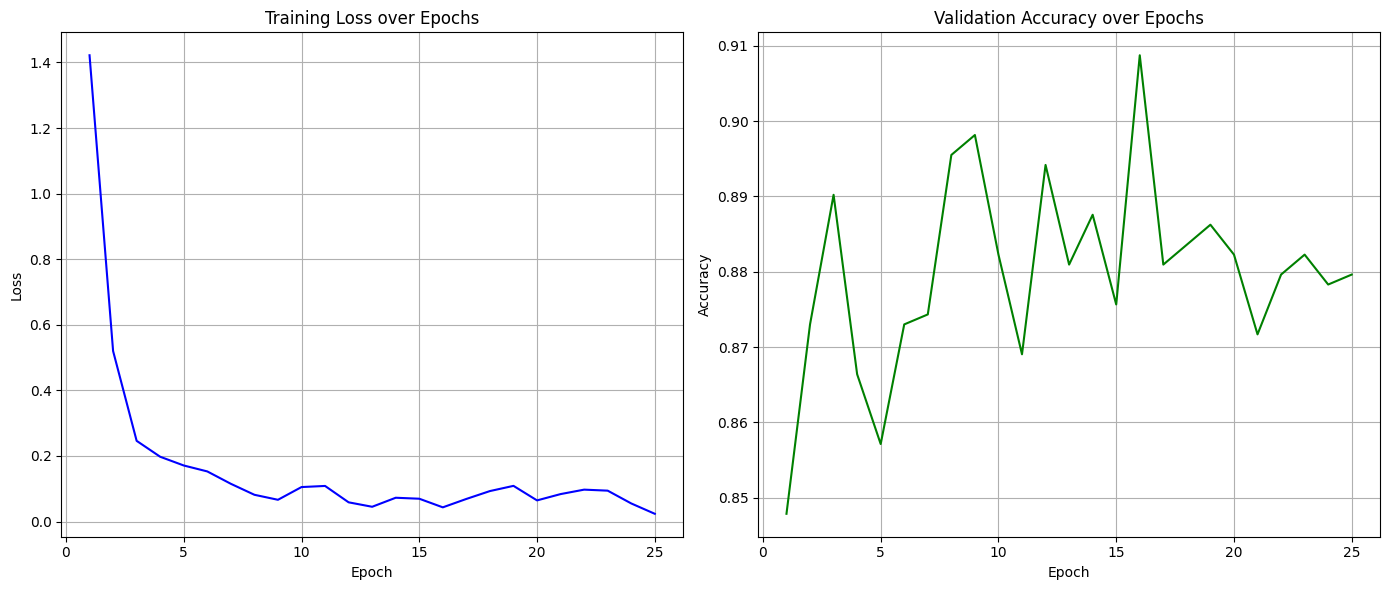

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm  # For ViT and other models
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
import time
from tqdm import tqdm
from PIL import Image
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler
import os
import matplotlib.pyplot as plt

# Define aesthetic categories
aesthetic_categories = ["Balance", "Color Harmony", "Depth & Perspective", "Texture & Brushwork"]

# Define model based on ResNet50 with custom heads for the 4 aesthetic classes
class AestheticModelWithResNet50(nn.Module):
    def __init__(self, num_classes=4):
        super(AestheticModelWithResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        # Get the in_features from ResNet50's final fully connected layer
        in_features = self.resnet.fc.in_features

        # Remove the final fully connected layer (so that we can add custom heads)
        self.resnet.fc = nn.Identity()

        # Custom heads for the 4 aesthetic classes
        self.balance_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Balance class
        )

        self.color_harmony_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Color Harmony class
        )

        self.depth_perspective_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Depth & Perspective class
        )

        self.texture_brushwork_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Texture & Brushwork class
        )

    def forward(self, x):
        features = self.resnet(x)
        balance = self.balance_head(features)
        color_harmony = self.color_harmony_head(features)
        depth_perspective = self.depth_perspective_head(features)
        texture_brushwork = self.texture_brushwork_head(features)

        return balance, color_harmony, depth_perspective, texture_brushwork


# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resNet50_model = AestheticModelWithResNet50(num_classes=4).to(device)
criterion = nn.BCEWithLogitsLoss()  # Suitable for multi-label classification
optimizer = optim.Adam(resNet50_model.parameters(), lr=1e-4)

# Training loop with progress bar and time tracking
num_epochs = 25
start_time = time.time()  # Start time for total training

train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    resNet50_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()  # Start time for this epoch

    # Initialize tqdm progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            balance, color_harmony, depth_perspective, texture_brushwork = resNet50_model(images)

            # Calculate loss for each output (balance, color harmony, etc.)
            loss_balance = criterion(balance.squeeze(), labels[:, 0])
            loss_color_harmony = criterion(color_harmony.squeeze(), labels[:, 1])
            loss_depth_perspective = criterion(depth_perspective.squeeze(), labels[:, 2])
            loss_texture_brushwork = criterion(texture_brushwork.squeeze(), labels[:, 3])

            # Total loss is the sum of all losses
            total_loss = loss_balance + loss_color_harmony + loss_depth_perspective + loss_texture_brushwork
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            # Update accuracy
            predictions = torch.cat([
                torch.sigmoid(balance),
                torch.sigmoid(color_harmony),
                torch.sigmoid(depth_perspective),
                torch.sigmoid(texture_brushwork)
            ], dim=1)

            # Binarize predictions (thresholding at 0.5)
            predicted_labels = (predictions > 0.5).float()

            # Compare predicted labels with the ground truth labels
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)  # Total labels for all 4 categories

            # Update the progress bar with loss information
            tepoch.set_postfix(loss=total_loss.item())

    epoch_end_time = time.time()  # End time for this epoch
    epoch_duration = epoch_end_time - epoch_start_time  # Duration of the epoch
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader)}")

    if total_train > 0:
        train_accuracy = correct_train / total_train  # Ensure division by non-zero total_train
        print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    else:
        print("Warning: Total train samples are zero.")

    train_losses.append(running_loss / len(train_loader))

    # Validation phase
    resNet50_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            balance, color_harmony, depth_perspective, texture_brushwork = resNet50_model(images)

            # Convert logits to probabilities (using sigmoid)
            predictions_balance = torch.sigmoid(balance)
            predictions_color_harmony = torch.sigmoid(color_harmony)
            predictions_depth_perspective = torch.sigmoid(depth_perspective)
            predictions_texture_brushwork = torch.sigmoid(texture_brushwork)

            # Compare predictions to actual labels
            predicted_labels_balance = (predictions_balance > 0.5).float()
            predicted_labels_color_harmony = (predictions_color_harmony > 0.5).float()
            predicted_labels_depth_perspective = (predictions_depth_perspective > 0.5).float()
            predicted_labels_texture_brushwork = (predictions_texture_brushwork > 0.5).float()

            correct_val += (predicted_labels_balance == labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_color_harmony == labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_depth_perspective == labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_texture_brushwork == labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4  # Total labels for all 4 categories

    val_accuracy = correct_val / total_val
    print(f"Epoch {epoch+1}/{num_epochs} Validation Accuracy: {val_accuracy * 100:.2f}%")
    val_accuracies.append(val_accuracy)

# Total time for training
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({(total_training_time / 60):.2f} minutes)")

# Plotting the Loss and Accuracy curves
plt.figure(figsize=(14, 6))

# Plot Training Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot Validation Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


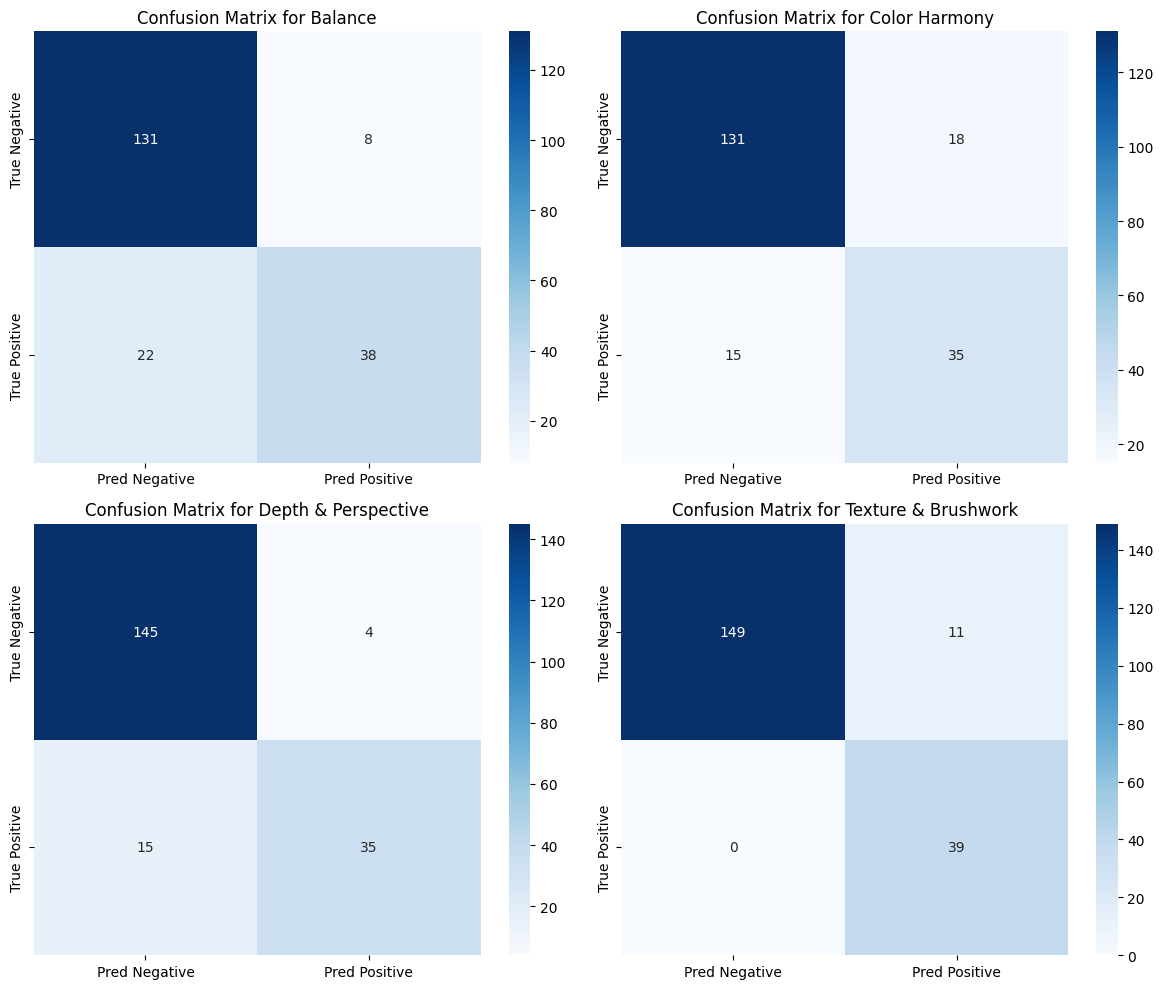

Test Accuracy: 88.32%
Precision: 73.87%
Recall: 73.87%
F1-Score: 73.87%


In [6]:
# Define aesthetic categories
aesthetic_categories = ["Balance", "Color Harmony", "Depth & Perspective", "Texture & Brushwork"]

# Set the model to evaluation mode
resNet50_model.eval()

# Initialize variables to hold predictions and ground truths
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        balance, color_harmony, depth_perspective, texture_brushwork = resNet50_model(images)

        # Convert logits to probabilities using sigmoid
        predictions_balance = torch.sigmoid(balance)
        predictions_color_harmony = torch.sigmoid(color_harmony)
        predictions_depth_perspective = torch.sigmoid(depth_perspective)
        predictions_texture_brushwork = torch.sigmoid(texture_brushwork)

        # Binarize predictions (thresholding at 0.5)
        predicted_labels_balance = (predictions_balance > 0.5).float()
        predicted_labels_color_harmony = (predictions_color_harmony > 0.5).float()
        predicted_labels_depth_perspective = (predictions_depth_perspective > 0.5).float()
        predicted_labels_texture_brushwork = (predictions_texture_brushwork > 0.5).float()

        # Concatenate the predictions for all categories (multi-label classification)
        all_predictions.append(torch.cat((predicted_labels_balance, predicted_labels_color_harmony,
                                          predicted_labels_depth_perspective, predicted_labels_texture_brushwork), dim=1))
        all_labels.append(labels)

# Convert the lists to tensors
all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Calculate accuracy
accuracy = (all_predictions == all_labels).sum() / all_labels.size

# Calculate Precision, Recall, and F1-Score (using 'samples' average for multi-label)
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')

# Generate Multi-label Confusion Matrix (for each class)
mcm = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'], ax=ax)
    ax.set_title(f'Confusion Matrix for {aesthetic_categories[i]}')

plt.tight_layout()
plt.show()

# Display the evaluation metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")


In [7]:
import torch

# Assuming you have a model defined as `model`
# Example:
# model = AestheticModel()  # Replace with your actual model definition

# Convert the model to TorchScript (this assumes the model's forward function is compatible)
scripted_model = torch.jit.script(resNet50_model)  # Convert to TorchScript

# Save the TorchScript model to a file
torch.jit.save(scripted_model, "/content/aesthetic_resNet50_model.pth")

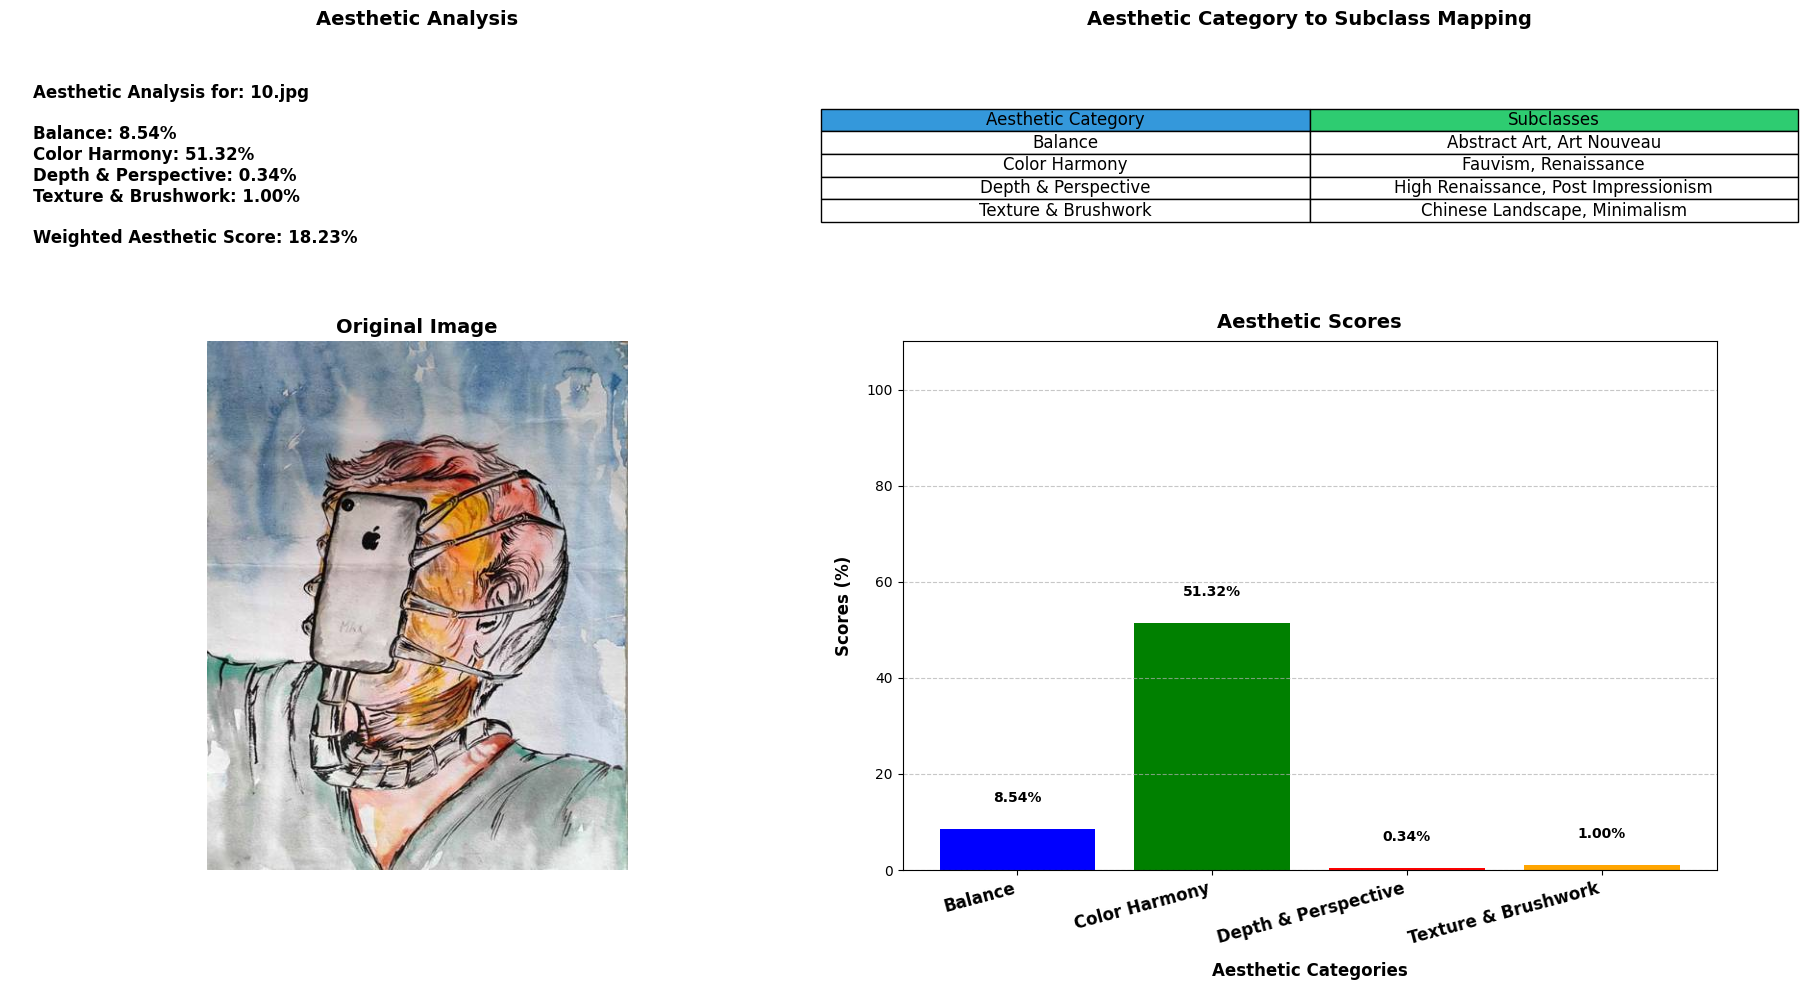

In [9]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import transforms
from PIL import Image

# Load TorchScript aesthetic model
scripted_model = torch.jit.load("/content/CSE499-MerakiNexus-AI_And_Defi/aesthetic_model/models/aesthetic_resNet50_model.pth")  # Update path
scripted_model.eval()

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scripted_model.to(device)

# Define aesthetic categories and weights
aesthetic_categories = [
    "Balance",
    "Color Harmony",
    "Depth & Perspective",
    "Texture & Brushwork"
]

weights = {
    "Balance": 0.3,
    "Color Harmony": 0.3,
    "Depth & Perspective": 0.2,
    "Texture & Brushwork": 0.2
}

category_to_subclasses = {
    "Balance": ["Abstract Art", "Art Nouveau"],
    "Color Harmony": ["Fauvism", "Renaissance"],
    "Depth & Perspective": ["High Renaissance", "Post Impressionism"],
    "Texture & Brushwork": ["Chinese Landscape", "Minimalism"]
}

# Preprocess function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image_tensor

# Inference function
def run_inference(image_path):
    image_tensor = preprocess_image(image_path)
    with torch.no_grad():
        outputs = scripted_model(image_tensor)

        balance, color_harmony, depth_perspective, texture_brushwork = outputs

        scores = {
            "Balance": torch.sigmoid(balance).item() * 100,
            "Color Harmony": torch.sigmoid(color_harmony).item() * 100,
            "Depth & Perspective": torch.sigmoid(depth_perspective).item() * 100,
            "Texture & Brushwork": torch.sigmoid(texture_brushwork).item() * 100
        }

    return scores

# Visualization function
def visualize_aesthetic_scores(image_path):
    scores = run_inference(image_path)
    weighted_score = sum(scores[k] * weights[k] for k in scores)

    mapping_df = pd.DataFrame(
        [(cat, ", ".join(subs)) for cat, subs in category_to_subclasses.items()],
        columns=["Aesthetic Category", "Subclasses"]
    )

    fig, axes = plt.subplots(2, 2, figsize=(18, 10), gridspec_kw={'height_ratios': [1, 2]})

    # Text summary
    summary = f"""
    Aesthetic Analysis for: {image_path}

    Balance: {scores["Balance"]:.2f}%
    Color Harmony: {scores["Color Harmony"]:.2f}%
    Depth & Perspective: {scores["Depth & Perspective"]:.2f}%
    Texture & Brushwork: {scores["Texture & Brushwork"]:.2f}%

    Weighted Aesthetic Score: {weighted_score:.2f}%
    """
    axes[0, 0].text(0, 0.5, summary, fontsize=12, fontweight="bold", va='center', ha='left')
    axes[0, 0].axis("off")
    axes[0, 0].set_title("Aesthetic Analysis", fontsize=14, fontweight="bold")

    # Subclass mapping table
    axes[0, 1].axis("tight")
    axes[0, 1].axis("off")
    table = axes[0, 1].table(
        cellText=mapping_df.values,
        colLabels=mapping_df.columns,
        cellLoc="center",
        loc="center",
        colColours=["#3498db", "#2ecc71"]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    axes[0, 1].set_title("Aesthetic Category to Subclass Mapping", fontsize=14, fontweight="bold")

    # Original image
    image = Image.open(image_path)
    axes[1, 0].imshow(image)
    axes[1, 0].axis("off")
    axes[1, 0].set_title("Original Image", fontsize=14, fontweight='bold')

    # Bar chart
    bars = axes[1, 1].bar(scores.keys(), scores.values(), color=['blue', 'green', 'red', 'orange'])
    for bar in bars:
        axes[1, 1].text(bar.get_x() + bar.get_width()/2,
                        bar.get_height() + 5,
                        f'{bar.get_height():.2f}%',
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
    axes[1, 1].set_xticks(range(len(scores)))
    axes[1, 1].set_xticklabels(scores.keys(), fontsize=12, fontweight='bold', rotation=15, ha='right')
    axes[1, 1].set_xlabel('Aesthetic Categories', fontsize=12, fontweight='bold', labelpad=10)
    axes[1, 1].set_ylabel('Scores (%)', fontsize=12, fontweight='bold', labelpad=10)
    axes[1, 1].set_title('Aesthetic Scores', fontsize=14, fontweight='bold', pad=10)
    axes[1, 1].set_ylim(0, 110)
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Example usage
image_path = "1.jpg"  # Replace with your test image
visualize_aesthetic_scores(image_path)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 90.1MB/s]
Epoch 1/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=1.39]


Epoch 1/25 completed in 54.59 seconds.
Epoch Loss: 1.364165980969706
Train Accuracy: 84.61%


Epoch 1/25 Validation Accuracy: 86.11%


Epoch 2/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.914]


Epoch 2/25 completed in 54.47 seconds.
Epoch Loss: 0.5638922647603096
Train Accuracy: 94.90%


Epoch 2/25 Validation Accuracy: 86.90%


Epoch 3/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.13batch/s, loss=0.464]


Epoch 3/25 completed in 54.98 seconds.
Epoch Loss: 0.2808681712636063
Train Accuracy: 97.41%


Epoch 3/25 Validation Accuracy: 87.96%


Epoch 4/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.223]


Epoch 4/25 completed in 54.57 seconds.
Epoch Loss: 0.1851308811455965
Train Accuracy: 98.52%


Epoch 4/25 Validation Accuracy: 87.70%


Epoch 5/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.865]


Epoch 5/25 completed in 54.49 seconds.
Epoch Loss: 0.24087912949823564
Train Accuracy: 97.79%


Epoch 5/25 Validation Accuracy: 87.17%


Epoch 6/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.13batch/s, loss=0.198]


Epoch 6/25 completed in 54.72 seconds.
Epoch Loss: 0.16687449401304608
Train Accuracy: 98.53%


Epoch 6/25 Validation Accuracy: 87.70%


Epoch 7/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.0548]


Epoch 7/25 completed in 54.46 seconds.
Epoch Loss: 0.13325350852532974
Train Accuracy: 98.91%


Epoch 7/25 Validation Accuracy: 86.38%


Epoch 8/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.105]


Epoch 8/25 completed in 54.55 seconds.
Epoch Loss: 0.15451209114924555
Train Accuracy: 98.58%


Epoch 8/25 Validation Accuracy: 89.15%


Epoch 9/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.13batch/s, loss=0.0187]


Epoch 9/25 completed in 54.64 seconds.
Epoch Loss: 0.0799305583650787
Train Accuracy: 99.43%


Epoch 9/25 Validation Accuracy: 86.38%


Epoch 10/25 Training: 100%|██████████| 62/62 [00:53<00:00,  1.15batch/s, loss=0.0192]


Epoch 10/25 completed in 53.96 seconds.
Epoch Loss: 0.04310519608008044
Train Accuracy: 99.71%


Epoch 10/25 Validation Accuracy: 87.57%


Epoch 11/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.15batch/s, loss=0.00477]


Epoch 11/25 completed in 54.04 seconds.
Epoch Loss: 0.08943505359873656
Train Accuracy: 99.10%


Epoch 11/25 Validation Accuracy: 86.90%


Epoch 12/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.00428]


Epoch 12/25 completed in 54.49 seconds.
Epoch Loss: 0.07431354756737428
Train Accuracy: 99.20%


Epoch 12/25 Validation Accuracy: 88.10%


Epoch 13/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.0444]


Epoch 13/25 completed in 54.18 seconds.
Epoch Loss: 0.05103900983569122
Train Accuracy: 99.52%


Epoch 13/25 Validation Accuracy: 89.29%


Epoch 14/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.00357]


Epoch 14/25 completed in 54.19 seconds.
Epoch Loss: 0.0913617454108692
Train Accuracy: 99.25%


Epoch 14/25 Validation Accuracy: 87.17%


Epoch 15/25 Training: 100%|██████████| 62/62 [00:53<00:00,  1.15batch/s, loss=1.7]


Epoch 15/25 completed in 53.95 seconds.
Epoch Loss: 0.09469434643735088
Train Accuracy: 99.47%


Epoch 15/25 Validation Accuracy: 88.36%


Epoch 16/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.00249]


Epoch 16/25 completed in 54.52 seconds.
Epoch Loss: 0.04286073542185007
Train Accuracy: 99.61%


Epoch 16/25 Validation Accuracy: 89.15%


Epoch 17/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.13batch/s, loss=0.402]


Epoch 17/25 completed in 54.74 seconds.
Epoch Loss: 0.02195486064339357
Train Accuracy: 99.87%


Epoch 17/25 Validation Accuracy: 89.29%


Epoch 18/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.13batch/s, loss=0.002]


Epoch 18/25 completed in 54.64 seconds.
Epoch Loss: 0.015180275629034205
Train Accuracy: 99.89%


Epoch 18/25 Validation Accuracy: 88.76%


Epoch 19/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.13batch/s, loss=0.0106]


Epoch 19/25 completed in 54.79 seconds.
Epoch Loss: 0.011875580008622379
Train Accuracy: 99.96%


Epoch 19/25 Validation Accuracy: 89.15%


Epoch 20/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.0291]


Epoch 20/25 completed in 54.60 seconds.
Epoch Loss: 0.006628147132071336
Train Accuracy: 99.96%


Epoch 20/25 Validation Accuracy: 88.10%


Epoch 21/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.000644]


Epoch 21/25 completed in 54.41 seconds.
Epoch Loss: 0.005835227532623967
Train Accuracy: 99.96%


Epoch 21/25 Validation Accuracy: 88.89%


Epoch 22/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.126]


Epoch 22/25 completed in 54.34 seconds.
Epoch Loss: 0.005448028632541067
Train Accuracy: 99.99%


Epoch 22/25 Validation Accuracy: 89.42%


Epoch 23/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.13batch/s, loss=0.0054]


Epoch 23/25 completed in 54.73 seconds.
Epoch Loss: 0.012725756423371364
Train Accuracy: 99.95%


Epoch 23/25 Validation Accuracy: 89.81%


Epoch 24/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.13batch/s, loss=0.000692]


Epoch 24/25 completed in 54.91 seconds.
Epoch Loss: 0.004971459289194054
Train Accuracy: 99.96%


Epoch 24/25 Validation Accuracy: 87.04%


Epoch 25/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.13batch/s, loss=0.00362]


Epoch 25/25 completed in 54.73 seconds.
Epoch Loss: 0.0058105649204076
Train Accuracy: 99.96%


Epoch 25/25 Validation Accuracy: 87.96%

Total Training Time: 1450.36 seconds (24.17 minutes)
Test Accuracy: 89.45%


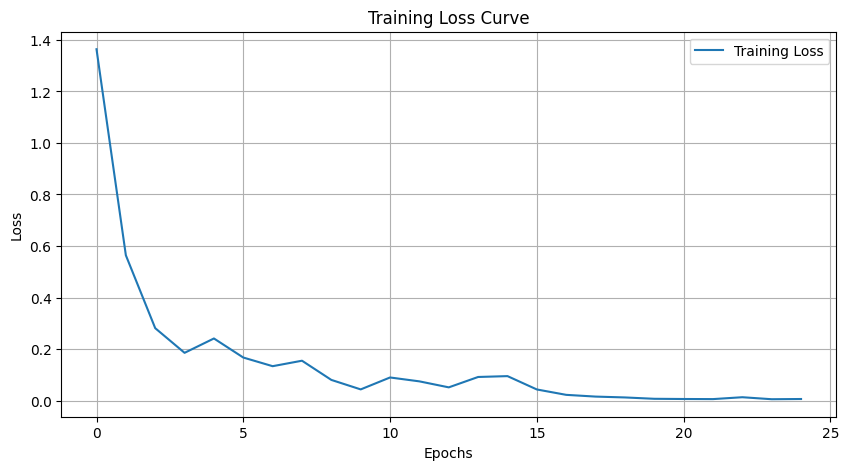

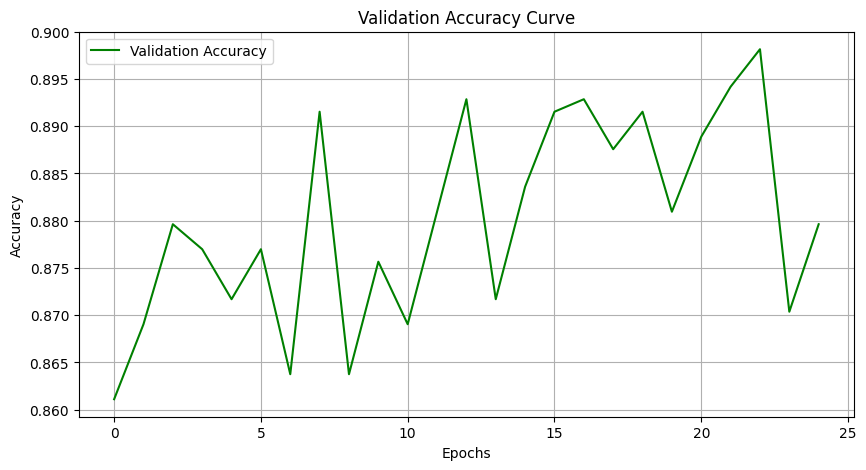

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm  # For ViT and other models
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
import time
from tqdm import tqdm
from PIL import Image
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt

class AestheticModelWithResNet101(nn.Module):
    def __init__(self, num_classes=4):
        super(AestheticModelWithResNet101, self).__init__()
        self.resnet = models.resnet101(pretrained=True)

        # Get the in_features from ResNet101's final fully connected layer
        in_features = self.resnet.fc.in_features

        # Remove the final fully connected layer (so that we can add custom heads)
        self.resnet.fc = nn.Identity()

        # Custom heads for the 4 aesthetic classes
        self.balance_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Balance class
        )

        self.color_harmony_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Color Harmony class
        )

        self.depth_perspective_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Depth & Perspective class
        )

        self.texture_brushwork_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Texture & Brushwork class
        )

    def forward(self, x):
        features = self.resnet(x)
        balance = self.balance_head(features)
        color_harmony = self.color_harmony_head(features)
        depth_perspective = self.depth_perspective_head(features)
        texture_brushwork = self.texture_brushwork_head(features)

        return balance, color_harmony, depth_perspective, texture_brushwork

# Initialize model, loss function, and optimizer
resNet101_model = AestheticModelWithResNet101(num_classes=4).to(device)
criterion = nn.BCEWithLogitsLoss()  # Suitable for multi-label classification
optimizer = optim.AdamW(resNet101_model.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler (reduce learning rate when validation loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Lists to store loss and validation accuracy for plotting
train_losses = []
val_accuracies = []

# Training loop with progress bar and time tracking
num_epochs = 25
start_time = time.time()  # Start time for total training

for epoch in range(num_epochs):
    resNet101_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()  # Start time for this epoch

    # Initialize tqdm progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            balance, color_harmony, depth_perspective, texture_brushwork = resNet101_model(images)

            # Calculate loss for each output (balance, color harmony, etc.)
            loss_balance = criterion(balance.squeeze(), labels[:, 0])
            loss_color_harmony = criterion(color_harmony.squeeze(), labels[:, 1])
            loss_depth_perspective = criterion(depth_perspective.squeeze(), labels[:, 2])
            loss_texture_brushwork = criterion(texture_brushwork.squeeze(), labels[:, 3])

            # Total loss is the sum of all losses
            total_loss = loss_balance + loss_color_harmony + loss_depth_perspective + loss_texture_brushwork
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            # Update accuracy
            predictions = torch.cat([
                torch.sigmoid(balance),
                torch.sigmoid(color_harmony),
                torch.sigmoid(depth_perspective),
                torch.sigmoid(texture_brushwork)
            ], dim=1)

            # Binarize predictions (thresholding at 0.5)
            predicted_labels = (predictions > 0.5).float()

            # Compare predicted labels with the ground truth labels
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)  # Total labels for all 4 categories

            # Update the progress bar with loss information
            tepoch.set_postfix(loss=total_loss.item())

    epoch_end_time = time.time()  # End time for this epoch
    epoch_duration = epoch_end_time - epoch_start_time  # Duration of the epoch
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader)}")

    if total_train > 0:
        train_accuracy = correct_train / total_train  # Ensure division by non-zero total_train
        print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    else:
        print("Warning: Total train samples are zero.")

    train_losses.append(running_loss / len(train_loader))  # Store the train loss for each epoch

    # Validation phase
    resNet101_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            balance, color_harmony, depth_perspective, texture_brushwork = resNet101_model(images)

            # Convert logits to probabilities (using sigmoid)
            predictions_balance = torch.sigmoid(balance)
            predictions_color_harmony = torch.sigmoid(color_harmony)
            predictions_depth_perspective = torch.sigmoid(depth_perspective)
            predictions_texture_brushwork = torch.sigmoid(texture_brushwork)

            # Compare predictions to actual labels
            predicted_labels_balance = (predictions_balance > 0.5).float()
            predicted_labels_color_harmony = (predictions_color_harmony > 0.5).float()
            predicted_labels_depth_perspective = (predictions_depth_perspective > 0.5).float()
            predicted_labels_texture_brushwork = (predictions_texture_brushwork > 0.5).float()

            correct_val += (predicted_labels_balance == labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_color_harmony == labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_depth_perspective == labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_texture_brushwork == labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4  # Total labels for all 4 categories

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)  # Store the validation accuracy for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Step the learning rate scheduler
    scheduler.step(running_loss)

# Total time for training
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({(total_training_time / 60):.2f} minutes)")

# Test Accuracy Evaluation
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        balance, color_harmony, depth_perspective, texture_brushwork = resNet101_model(images)

        # Convert logits to probabilities
        predictions = torch.cat([
            torch.sigmoid(balance),
            torch.sigmoid(color_harmony),
            torch.sigmoid(depth_perspective),
            torch.sigmoid(texture_brushwork)
        ], dim=1)

        # Binarize predictions (threshold = 0.5)
        predicted_labels = (predictions > 0.5).float()

        # Compute accuracy
        correct_test += (predicted_labels == labels).sum().item()
        total_test += labels.numel()

# Compute final test accuracy
test_accuracy = correct_test / total_test * 100

# Display results
print(f"Test Accuracy: {test_accuracy:.2f}%")

# --- Now plotting the loss and accuracy curves ---
# Plotting the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)

# Plotting the validation accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), val_accuracies, label="Validation Accuracy", color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.grid(True)

plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


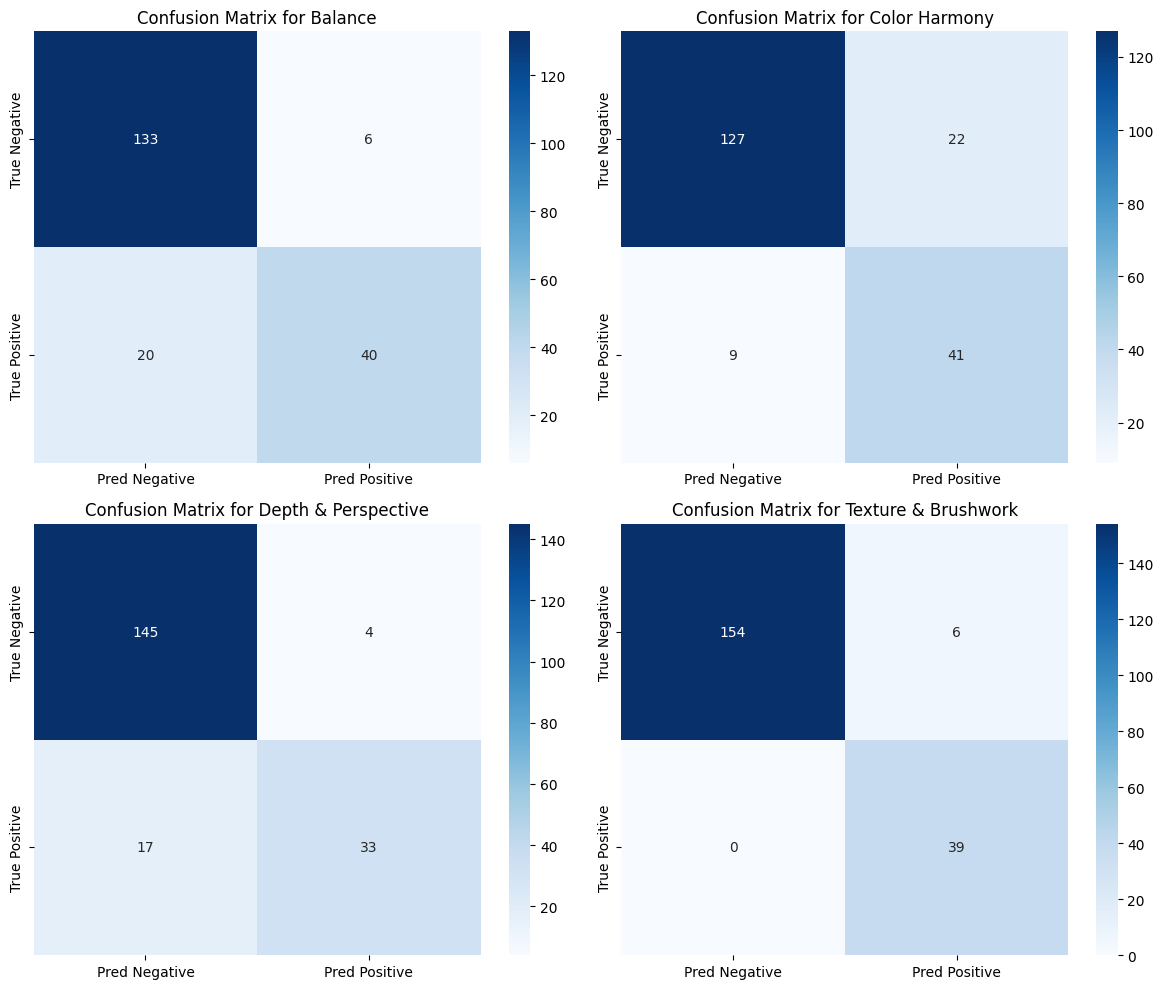

Test Accuracy: 89.45%
Precision: 76.63%
Recall: 76.88%
F1-Score: 76.72%


In [ ]:
# Define aesthetic categories
aesthetic_categories = ["Balance", "Color Harmony", "Depth & Perspective", "Texture & Brushwork"]

# Set the model to evaluation mode
resNet101_model.eval()

# Initialize variables to hold predictions and ground truths
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        balance, color_harmony, depth_perspective, texture_brushwork = resNet101_model(images)

        # Convert logits to probabilities using sigmoid
        predictions_balance = torch.sigmoid(balance)
        predictions_color_harmony = torch.sigmoid(color_harmony)
        predictions_depth_perspective = torch.sigmoid(depth_perspective)
        predictions_texture_brushwork = torch.sigmoid(texture_brushwork)

        # Binarize predictions (thresholding at 0.5)
        predicted_labels_balance = (predictions_balance > 0.5).float()
        predicted_labels_color_harmony = (predictions_color_harmony > 0.5).float()
        predicted_labels_depth_perspective = (predictions_depth_perspective > 0.5).float()
        predicted_labels_texture_brushwork = (predictions_texture_brushwork > 0.5).float()

        # Concatenate the predictions for all categories (multi-label classification)
        all_predictions.append(torch.cat((predicted_labels_balance, predicted_labels_color_harmony,
                                          predicted_labels_depth_perspective, predicted_labels_texture_brushwork), dim=1))
        all_labels.append(labels)

# Convert the lists to tensors
all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Calculate accuracy
accuracy = (all_predictions == all_labels).sum() / all_labels.size

# Calculate Precision, Recall, and F1-Score (using 'samples' average for multi-label)
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')

# Generate Multi-label Confusion Matrix (for each class)
mcm = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'], ax=ax)
    ax.set_title(f'Confusion Matrix for {aesthetic_categories[i]}')

plt.tight_layout()
plt.show()

# Display the evaluation metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm  # For ViT and other models
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
import time
from tqdm import tqdm
from PIL import Image
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the model based on ViT with custom heads for the 4 aesthetic classes
class AestheticModelWithViT(nn.Module):
    def __init__(self, num_classes=4):
        super(AestheticModelWithViT, self).__init__()
        # Load pre-trained ViT model
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)

        # Get the input features from ViT's final fully connected layer
        in_features = self.vit.head.in_features
        self.vit.head = nn.Identity()  # Remove the original head to add custom heads

        # Custom heads for each of the 4 aesthetic categories
        self.balance_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout to prevent overfitting
            nn.Linear(128, 1)  # Output for Balance class
        )

        self.color_harmony_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout to prevent overfitting
            nn.Linear(128, 1)  # Output for Color Harmony class
        )

        self.depth_perspective_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout to prevent overfitting
            nn.Linear(128, 1)  # Output for Depth & Perspective class
        )

        self.texture_brushwork_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout to prevent overfitting
            nn.Linear(128, 1)  # Output for Texture & Brushwork class
        )

    def forward(self, x):
        # Forward pass through ViT
        features = self.vit(x)

        # Get the output from each custom head
        balance = self.balance_head(features)
        color_harmony = self.color_harmony_head(features)
        depth_perspective = self.depth_perspective_head(features)
        texture_brushwork = self.texture_brushwork_head(features)

        return balance, color_harmony, depth_perspective, texture_brushwork


# Initialize model, loss function, and optimizer
vit_model = AestheticModelWithViT(num_classes=4).to(device)
criterion = nn.BCEWithLogitsLoss()  # Suitable for multi-label classification

# Use AdamW optimizer for better regularization (weight decay) and improved performance
optimizer = optim.AdamW(vit_model.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler (reduce learning rate when validation loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Training loop with progress bar and time tracking
num_epochs = 25
start_time = time.time()  # Start time for total training

for epoch in range(num_epochs):
    vit_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()  # Start time for this epoch

    # Initialize tqdm progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            balance, color_harmony, depth_perspective, texture_brushwork = vit_model(images)

            # Calculate loss for each output (balance, color harmony, etc.)
            loss_balance = criterion(balance.squeeze(), labels[:, 0])
            loss_color_harmony = criterion(color_harmony.squeeze(), labels[:, 1])
            loss_depth_perspective = criterion(depth_perspective.squeeze(), labels[:, 2])
            loss_texture_brushwork = criterion(texture_brushwork.squeeze(), labels[:, 3])

            # Total loss is the sum of all losses
            total_loss = loss_balance + loss_color_harmony + loss_depth_perspective + loss_texture_brushwork
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            # Update accuracy
            predictions = torch.cat([
                torch.sigmoid(balance),
                torch.sigmoid(color_harmony),
                torch.sigmoid(depth_perspective),
                torch.sigmoid(texture_brushwork)
            ], dim=1)

            # Binarize predictions (thresholding at 0.5)
            predicted_labels = (predictions > 0.5).float()

            # Compare predicted labels with the ground truth labels
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)  # Total labels for all 4 categories

            # Update the progress bar with loss information
            tepoch.set_postfix(loss=total_loss.item())

    epoch_end_time = time.time()  # End time for this epoch
    epoch_duration = epoch_end_time - epoch_start_time  # Duration of the epoch
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader)}")
    print(f"Train Accuracy: {correct_train / total_train:.2f}%")

    # Validation phase
    vit_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            balance, color_harmony, depth_perspective, texture_brushwork = vit_model(images)

            # Convert logits to probabilities (using sigmoid)
            predictions_balance = torch.sigmoid(balance)
            predictions_color_harmony = torch.sigmoid(color_harmony)
            predictions_depth_perspective = torch.sigmoid(depth_perspective)
            predictions_texture_brushwork = torch.sigmoid(texture_brushwork)

            # Compare predictions to actual labels
            predicted_labels_balance = (predictions_balance > 0.5).float()
            predicted_labels_color_harmony = (predictions_color_harmony > 0.5).float()
            predicted_labels_depth_perspective = (predictions_depth_perspective > 0.5).float()
            predicted_labels_texture_brushwork = (predictions_texture_brushwork > 0.5).float()

            correct_val += (predicted_labels_balance == labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_color_harmony == labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_depth_perspective == labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_texture_brushwork == labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4  # Total labels for all 4 categories

    val_accuracy = correct_val / total_val
    print(f"Epoch {epoch+1}/{num_epochs} Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Step the learning rate scheduler
    scheduler.step(running_loss)

# Total time for training
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({(total_training_time / 60):.2f} minutes)")

# Test Accuracy Evaluation
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        balance, color_harmony, depth_perspective, texture_brushwork = vit_model(images)

        # Convert logits to probabilities
        predictions = torch.cat([
            torch.sigmoid(balance),
            torch.sigmoid(color_harmony),
            torch.sigmoid(depth_perspective),
            torch.sigmoid(texture_brushwork)
        ], dim=1)

        # Binarize predictions (threshold = 0.5)
        predicted_labels = (predictions > 0.5).float()

        # Compute accuracy
        correct_test += (predicted_labels == labels).sum().item()
        total_test += labels.numel()

# Compute final test accuracy
test_accuracy = correct_test / total_test * 100

# Display results
print(f"Test Accuracy: {test_accuracy:.2f}%")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/25 Training: 100%|██████████| 62/62 [01:20<00:00,  1.31s/batch, loss=1.69]


Epoch 1/25 completed in 80.96 seconds.
Epoch Loss: 1.7799184206993348
Train Accuracy: 0.79%


Epoch 1/25 Validation Accuracy: 80.82%


Epoch 2/25 Training: 100%|██████████| 62/62 [01:22<00:00,  1.33s/batch, loss=0.503]


Epoch 2/25 completed in 82.71 seconds.
Epoch Loss: 1.0936545248954528
Train Accuracy: 0.89%


Epoch 2/25 Validation Accuracy: 85.32%


Epoch 3/25 Training: 100%|██████████| 62/62 [01:25<00:00,  1.38s/batch, loss=1.39]


Epoch 3/25 completed in 85.86 seconds.
Epoch Loss: 0.7577602320140407
Train Accuracy: 0.93%


Epoch 3/25 Validation Accuracy: 80.56%


Epoch 4/25 Training: 100%|██████████| 62/62 [01:27<00:00,  1.41s/batch, loss=0.347]


Epoch 4/25 completed in 87.26 seconds.
Epoch Loss: 0.418138385780396
Train Accuracy: 0.96%


Epoch 4/25 Validation Accuracy: 82.94%


Epoch 5/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.42s/batch, loss=0.202]


Epoch 5/25 completed in 88.33 seconds.
Epoch Loss: 0.330396770559732
Train Accuracy: 0.97%


Epoch 5/25 Validation Accuracy: 82.80%


Epoch 6/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.43s/batch, loss=0.132]


Epoch 6/25 completed in 88.91 seconds.
Epoch Loss: 0.24856940763551863
Train Accuracy: 0.98%


Epoch 6/25 Validation Accuracy: 83.99%


Epoch 7/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.43s/batch, loss=0.276]


Epoch 7/25 completed in 88.64 seconds.
Epoch Loss: 0.223498864580066
Train Accuracy: 0.98%


Epoch 7/25 Validation Accuracy: 83.47%


Epoch 8/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.43s/batch, loss=0.0596]


Epoch 8/25 completed in 88.49 seconds.
Epoch Loss: 0.3554702838882804
Train Accuracy: 0.97%


Epoch 8/25 Validation Accuracy: 79.37%


Epoch 9/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.43s/batch, loss=0.0347]


Epoch 9/25 completed in 88.90 seconds.
Epoch Loss: 0.12829469518375494
Train Accuracy: 0.99%


Epoch 9/25 Validation Accuracy: 82.14%


Epoch 10/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.43s/batch, loss=0.0115]


Epoch 10/25 completed in 88.74 seconds.
Epoch Loss: 0.16391586229926156
Train Accuracy: 0.99%


Epoch 10/25 Validation Accuracy: 80.95%


Epoch 11/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.42s/batch, loss=0.269]


Epoch 11/25 completed in 88.19 seconds.
Epoch Loss: 0.12180733378045261
Train Accuracy: 0.99%


Epoch 11/25 Validation Accuracy: 81.61%


Epoch 12/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.43s/batch, loss=0.211]


Epoch 12/25 completed in 88.93 seconds.
Epoch Loss: 0.13299806061531266
Train Accuracy: 0.99%


Epoch 12/25 Validation Accuracy: 83.33%


Epoch 13/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.43s/batch, loss=0.0037]


Epoch 13/25 completed in 88.59 seconds.
Epoch Loss: 0.09039996585042606
Train Accuracy: 0.99%


Epoch 13/25 Validation Accuracy: 85.58%


Epoch 14/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.43s/batch, loss=0.013]


Epoch 14/25 completed in 88.92 seconds.
Epoch Loss: 0.06944569607543188
Train Accuracy: 1.00%


Epoch 14/25 Validation Accuracy: 84.92%


Epoch 15/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.43s/batch, loss=0.00294]


Epoch 15/25 completed in 88.91 seconds.
Epoch Loss: 0.1645314142168049
Train Accuracy: 0.99%


Epoch 15/25 Validation Accuracy: 82.41%


Epoch 16/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.43s/batch, loss=0.311]


Epoch 16/25 completed in 88.69 seconds.
Epoch Loss: 0.17502415895972762
Train Accuracy: 0.98%


Epoch 16/25 Validation Accuracy: 83.47%


Epoch 17/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.42s/batch, loss=0.157]


Epoch 17/25 completed in 88.23 seconds.
Epoch Loss: 0.06947820879624135
Train Accuracy: 0.99%


Epoch 17/25 Validation Accuracy: 81.35%


Epoch 18/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.43s/batch, loss=0.00441]


Epoch 18/25 completed in 88.57 seconds.
Epoch Loss: 0.007021624936662134
Train Accuracy: 1.00%


Epoch 18/25 Validation Accuracy: 81.75%


Epoch 19/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.43s/batch, loss=0.0599]


Epoch 19/25 completed in 88.83 seconds.
Epoch Loss: 0.07875092365711386
Train Accuracy: 1.00%


Epoch 19/25 Validation Accuracy: 84.26%


Epoch 20/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.43s/batch, loss=0.0185]


Epoch 20/25 completed in 88.70 seconds.
Epoch Loss: 0.15458394369230635
Train Accuracy: 0.99%


Epoch 20/25 Validation Accuracy: 84.26%


Epoch 21/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.43s/batch, loss=0.0727]


Epoch 21/25 completed in 88.92 seconds.
Epoch Loss: 0.0991564369910667
Train Accuracy: 0.99%


Epoch 21/25 Validation Accuracy: 84.66%


Epoch 22/25 Training: 100%|██████████| 62/62 [01:29<00:00,  1.44s/batch, loss=0.00823]


Epoch 22/25 completed in 89.28 seconds.
Epoch Loss: 0.1010439662382968
Train Accuracy: 0.99%


Epoch 22/25 Validation Accuracy: 85.32%


Epoch 23/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.43s/batch, loss=0.00429]


Epoch 23/25 completed in 88.46 seconds.
Epoch Loss: 0.010228499849026481
Train Accuracy: 1.00%


Epoch 23/25 Validation Accuracy: 85.45%


Epoch 24/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.44s/batch, loss=0.000969]


Epoch 24/25 completed in 88.98 seconds.
Epoch Loss: 0.0025278192413445083
Train Accuracy: 1.00%


Epoch 24/25 Validation Accuracy: 84.92%


Epoch 25/25 Training: 100%|██████████| 62/62 [01:28<00:00,  1.43s/batch, loss=0.000899]


Epoch 25/25 completed in 88.68 seconds.
Epoch Loss: 0.001327419032027284
Train Accuracy: 1.00%


Epoch 25/25 Validation Accuracy: 84.92%

Total Training Time: 2309.15 seconds (38.49 minutes)
Test Accuracy: 86.43%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


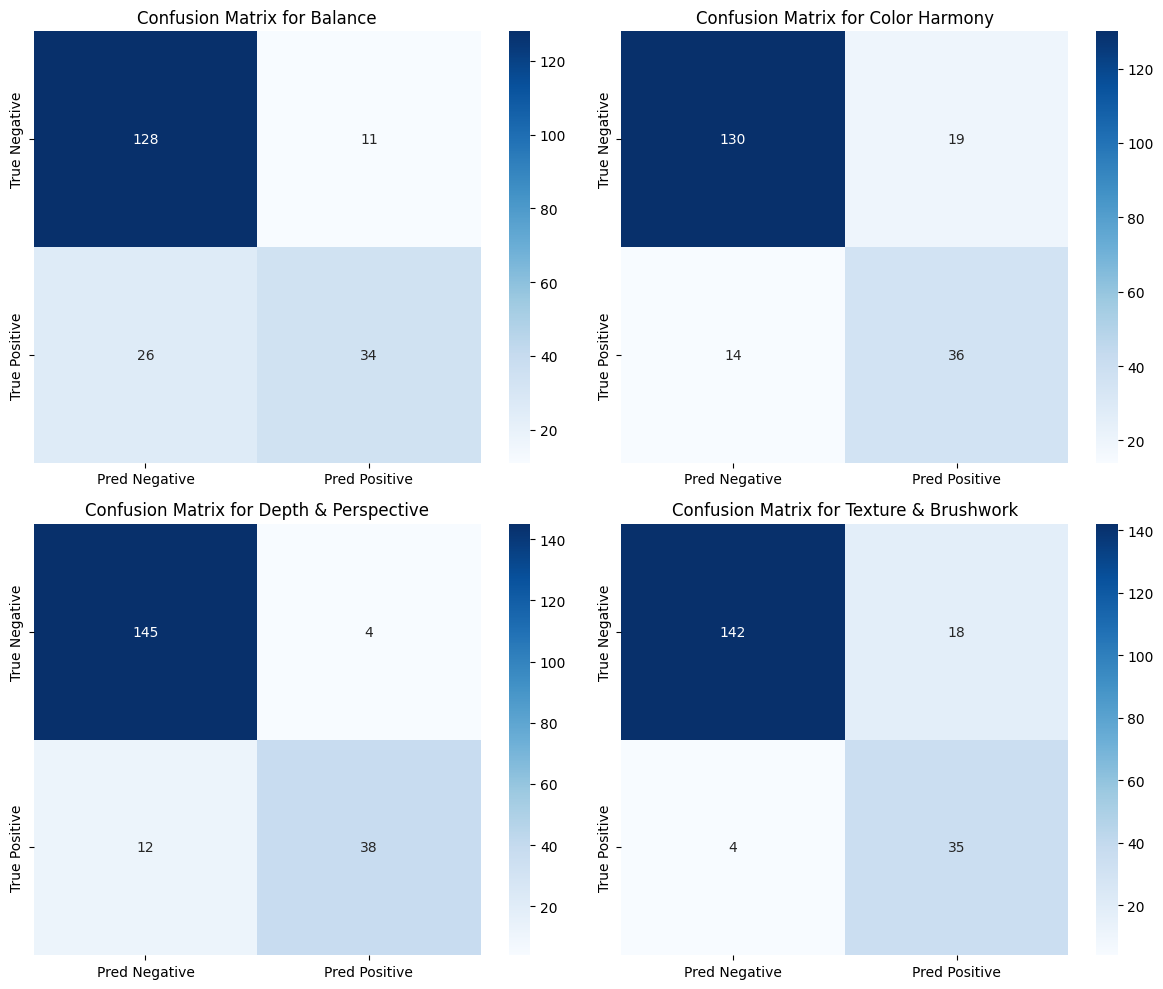

Test Accuracy: 86.43%
Precision: 71.86%
Recall: 71.86%
F1-Score: 71.86%


In [ ]:
# Define aesthetic categories
aesthetic_categories = ["Balance", "Color Harmony", "Depth & Perspective", "Texture & Brushwork"]

# Set the model to evaluation mode
vit_model.eval()

# Initialize variables to hold predictions and ground truths
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        balance, color_harmony, depth_perspective, texture_brushwork = vit_model(images)

        # Convert logits to probabilities using sigmoid
        predictions_balance = torch.sigmoid(balance)
        predictions_color_harmony = torch.sigmoid(color_harmony)
        predictions_depth_perspective = torch.sigmoid(depth_perspective)
        predictions_texture_brushwork = torch.sigmoid(texture_brushwork)

        # Binarize predictions (thresholding at 0.5)
        predicted_labels_balance = (predictions_balance > 0.5).float()
        predicted_labels_color_harmony = (predictions_color_harmony > 0.5).float()
        predicted_labels_depth_perspective = (predictions_depth_perspective > 0.5).float()
        predicted_labels_texture_brushwork = (predictions_texture_brushwork > 0.5).float()

        # Concatenate the predictions for all categories (multi-label classification)
        all_predictions.append(torch.cat((predicted_labels_balance, predicted_labels_color_harmony,
                                          predicted_labels_depth_perspective, predicted_labels_texture_brushwork), dim=1))
        all_labels.append(labels)

# Convert the lists to tensors
all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Calculate accuracy
accuracy = (all_predictions == all_labels).sum() / all_labels.size

# Calculate Precision, Recall, and F1-Score (using 'samples' average for multi-label)
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')

# Generate Multi-label Confusion Matrix (for each class)
mcm = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'], ax=ax)
    ax.set_title(f'Confusion Matrix for {aesthetic_categories[i]}')

plt.tight_layout()
plt.show()

# Display the evaluation metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm  # For EfficientNet and other models
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
import time
from tqdm import tqdm
from PIL import Image
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler

# Define model based on EfficientNet with custom heads for the 4 aesthetic classes
class AestheticModelWithEfficientNet(nn.Module):
    def __init__(self, num_classes=4):
        super(AestheticModelWithEfficientNet, self).__init__()
        # Load pre-trained EfficientNet model
        self.efficientnet = timm.create_model('efficientnet_b3', pretrained=True)

        # Get the input features from EfficientNet's final fully connected layer
        in_features = self.efficientnet.classifier.in_features
        self.efficientnet.classifier = nn.Identity()  # Remove the original head to add custom heads

        # Custom heads for each of the 4 aesthetic categories
        self.balance_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Balance class
        )

        self.color_harmony_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Color Harmony class
        )

        self.depth_perspective_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Depth & Perspective class
        )

        self.texture_brushwork_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Texture & Brushwork class
        )

    def forward(self, x):
        # Forward pass through EfficientNet
        features = self.efficientnet(x)

        # Get the output from each custom head
        balance = self.balance_head(features)
        color_harmony = self.color_harmony_head(features)
        depth_perspective = self.depth_perspective_head(features)
        texture_brushwork = self.texture_brushwork_head(features)

        return balance, color_harmony, depth_perspective, texture_brushwork


# Initialize model, loss function, and optimizer
efficientnet_model = AestheticModelWithEfficientNet(num_classes=4).to(device)
criterion = nn.BCEWithLogitsLoss()  # Suitable for multi-label classification

# Use AdamW optimizer for better regularization (weight decay) and improved performance
optimizer = optim.AdamW(efficientnet_model.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler (reduce learning rate when validation loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Training loop with progress bar and time tracking
num_epochs = 25
start_time = time.time()  # Start time for total training

for epoch in range(num_epochs):
    efficientnet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()  # Start time for this epoch

    # Initialize tqdm progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            balance, color_harmony, depth_perspective, texture_brushwork = efficientnet_model(images)

            # Calculate loss for each output (balance, color harmony, etc.)
            loss_balance = criterion(balance.squeeze(), labels[:, 0])
            loss_color_harmony = criterion(color_harmony.squeeze(), labels[:, 1])
            loss_depth_perspective = criterion(depth_perspective.squeeze(), labels[:, 2])
            loss_texture_brushwork = criterion(texture_brushwork.squeeze(), labels[:, 3])

            # Total loss is the sum of all losses
            total_loss = loss_balance + loss_color_harmony + loss_depth_perspective + loss_texture_brushwork
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            # Update accuracy
            predictions = torch.cat([
                torch.sigmoid(balance),
                torch.sigmoid(color_harmony),
                torch.sigmoid(depth_perspective),
                torch.sigmoid(texture_brushwork)
            ], dim=1)

            # Binarize predictions (thresholding at 0.5)
            predicted_labels = (predictions > 0.5).float()

            # Compare predicted labels with the ground truth labels
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)  # Total labels for all 4 categories

            # Update the progress bar with loss information
            tepoch.set_postfix(loss=total_loss.item())

    epoch_end_time = time.time()  # End time for this epoch
    epoch_duration = epoch_end_time - epoch_start_time  # Duration of the epoch
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader)}")
    print(f"Train Accuracy: {correct_train / total_train:.2f}%")

    # Validation phase
    efficientnet_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            balance, color_harmony, depth_perspective, texture_brushwork = efficientnet_model(images)

            # Convert logits to probabilities (using sigmoid)
            predictions_balance = torch.sigmoid(balance)
            predictions_color_harmony = torch.sigmoid(color_harmony)
            predictions_depth_perspective = torch.sigmoid(depth_perspective)
            predictions_texture_brushwork = torch.sigmoid(texture_brushwork)

            # Compare predictions to actual labels
            predicted_labels_balance = (predictions_balance > 0.5).float()
            predicted_labels_color_harmony = (predictions_color_harmony > 0.5).float()
            predicted_labels_depth_perspective = (predictions_depth_perspective > 0.5).float()
            predicted_labels_texture_brushwork = (predictions_texture_brushwork > 0.5).float()

            correct_val += (predicted_labels_balance == labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_color_harmony == labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_depth_perspective == labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_texture_brushwork == labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4  # Total labels for all 4 categories

    val_accuracy = correct_val / total_val
    print(f"Epoch {epoch+1}/{num_epochs} Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Step the learning rate scheduler
    scheduler.step(running_loss)

# Total time for training
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({(total_training_time / 60):.2f} minutes)")

# Test Accuracy Evaluation
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        balance, color_harmony, depth_perspective, texture_brushwork = efficientnet_model(images)

        # Convert logits to probabilities
        predictions = torch.cat([
            torch.sigmoid(balance),
            torch.sigmoid(color_harmony),
            torch.sigmoid(depth_perspective),
            torch.sigmoid(texture_brushwork)
        ], dim=1)

        # Binarize predictions (threshold = 0.5)
        predicted_labels = (predictions > 0.5).float()

        # Compute accuracy
        correct_test += (predicted_labels == labels).sum().item()
        total_test += labels.numel()

# Compute final test accuracy
test_accuracy = correct_test / total_test * 100

# Display results
print(f"Test Accuracy: {test_accuracy:.2f}%")


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Epoch 1/25 Training: 100%|██████████| 62/62 [00:44<00:00,  1.40batch/s, loss=1.32]


Epoch 1/25 completed in 44.42 seconds.
Epoch Loss: 2.078788741942375
Train Accuracy: 0.76%


Epoch 1/25 Validation Accuracy: 81.48%


Epoch 2/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.62batch/s, loss=1.48]


Epoch 2/25 completed in 38.37 seconds.
Epoch Loss: 1.133442614347704
Train Accuracy: 0.88%


Epoch 2/25 Validation Accuracy: 86.77%


Epoch 3/25 Training: 100%|██████████| 62/62 [00:39<00:00,  1.56batch/s, loss=0.43]


Epoch 3/25 completed in 39.70 seconds.
Epoch Loss: 0.453607042470286
Train Accuracy: 0.96%


Epoch 3/25 Validation Accuracy: 86.90%


Epoch 4/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.60batch/s, loss=0.292]


Epoch 4/25 completed in 38.77 seconds.
Epoch Loss: 0.1499381915576035
Train Accuracy: 0.99%


Epoch 4/25 Validation Accuracy: 87.17%


Epoch 5/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.59batch/s, loss=0.0242]


Epoch 5/25 completed in 38.96 seconds.
Epoch Loss: 0.06044518630651216
Train Accuracy: 1.00%


Epoch 5/25 Validation Accuracy: 87.04%


Epoch 6/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.59batch/s, loss=0.0272]


Epoch 6/25 completed in 38.97 seconds.
Epoch Loss: 0.028580284414572582
Train Accuracy: 1.00%


Epoch 6/25 Validation Accuracy: 86.51%


Epoch 7/25 Training: 100%|██████████| 62/62 [00:39<00:00,  1.57batch/s, loss=0.00953]


Epoch 7/25 completed in 39.51 seconds.
Epoch Loss: 0.02149102067004048
Train Accuracy: 1.00%


Epoch 7/25 Validation Accuracy: 87.83%


Epoch 8/25 Training: 100%|██████████| 62/62 [00:39<00:00,  1.58batch/s, loss=0.0113]


Epoch 8/25 completed in 39.14 seconds.
Epoch Loss: 0.021671304813466005
Train Accuracy: 1.00%


Epoch 8/25 Validation Accuracy: 87.17%


Epoch 9/25 Training: 100%|██████████| 62/62 [00:39<00:00,  1.55batch/s, loss=0.0144]


Epoch 9/25 completed in 39.98 seconds.
Epoch Loss: 0.03005910854816677
Train Accuracy: 1.00%


Epoch 9/25 Validation Accuracy: 86.38%


Epoch 10/25 Training: 100%|██████████| 62/62 [00:39<00:00,  1.59batch/s, loss=0.00459]


Epoch 10/25 completed in 39.11 seconds.
Epoch Loss: 0.02386455124078859
Train Accuracy: 1.00%


Epoch 10/25 Validation Accuracy: 86.51%


Epoch 11/25 Training: 100%|██████████| 62/62 [00:39<00:00,  1.57batch/s, loss=0.115]


Epoch 11/25 completed in 39.48 seconds.
Epoch Loss: 0.06297004362192726
Train Accuracy: 1.00%


Epoch 11/25 Validation Accuracy: 86.24%


Epoch 12/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.59batch/s, loss=0.00998]


Epoch 12/25 completed in 38.94 seconds.
Epoch Loss: 0.02864809392861301
Train Accuracy: 1.00%


Epoch 12/25 Validation Accuracy: 87.30%


Epoch 13/25 Training: 100%|██████████| 62/62 [00:39<00:00,  1.58batch/s, loss=0.00867]


Epoch 13/25 completed in 39.21 seconds.
Epoch Loss: 0.014977810833032333
Train Accuracy: 1.00%


Epoch 13/25 Validation Accuracy: 87.17%


Epoch 14/25 Training: 100%|██████████| 62/62 [00:39<00:00,  1.57batch/s, loss=0.00536]


Epoch 14/25 completed in 39.41 seconds.
Epoch Loss: 0.018972905575215155
Train Accuracy: 1.00%


Epoch 14/25 Validation Accuracy: 87.30%


Epoch 15/25 Training: 100%|██████████| 62/62 [00:39<00:00,  1.57batch/s, loss=0.113]


Epoch 15/25 completed in 39.56 seconds.
Epoch Loss: 0.014928443019368475
Train Accuracy: 1.00%


Epoch 15/25 Validation Accuracy: 87.04%


Epoch 16/25 Training: 100%|██████████| 62/62 [00:40<00:00,  1.55batch/s, loss=0.0351]


Epoch 16/25 completed in 40.04 seconds.
Epoch Loss: 0.010181998895976933
Train Accuracy: 1.00%


Epoch 16/25 Validation Accuracy: 85.71%


Epoch 17/25 Training: 100%|██████████| 62/62 [00:39<00:00,  1.59batch/s, loss=0.0395]


Epoch 17/25 completed in 39.12 seconds.
Epoch Loss: 0.014256008399365049
Train Accuracy: 1.00%


Epoch 17/25 Validation Accuracy: 85.98%


Epoch 18/25 Training: 100%|██████████| 62/62 [00:39<00:00,  1.57batch/s, loss=0.00194]


Epoch 18/25 completed in 39.51 seconds.
Epoch Loss: 0.006450569128520006
Train Accuracy: 1.00%


Epoch 18/25 Validation Accuracy: 86.24%


Epoch 19/25 Training: 100%|██████████| 62/62 [00:39<00:00,  1.59batch/s, loss=0.000347]


Epoch 19/25 completed in 39.04 seconds.
Epoch Loss: 0.013725058100516758
Train Accuracy: 1.00%


Epoch 19/25 Validation Accuracy: 85.85%


Epoch 20/25 Training: 100%|██████████| 62/62 [00:39<00:00,  1.56batch/s, loss=0.0015]


Epoch 20/25 completed in 39.71 seconds.
Epoch Loss: 0.017761112399204002
Train Accuracy: 1.00%


Epoch 20/25 Validation Accuracy: 86.11%


Epoch 21/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.59batch/s, loss=0.00786]


Epoch 21/25 completed in 38.93 seconds.
Epoch Loss: 0.014164079037014275
Train Accuracy: 1.00%


Epoch 21/25 Validation Accuracy: 85.58%


Epoch 22/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.60batch/s, loss=0.0196]


Epoch 22/25 completed in 38.78 seconds.
Epoch Loss: 0.004124367827429406
Train Accuracy: 1.00%


Epoch 22/25 Validation Accuracy: 86.51%


Epoch 23/25 Training: 100%|██████████| 62/62 [00:39<00:00,  1.58batch/s, loss=0.00106]


Epoch 23/25 completed in 39.26 seconds.
Epoch Loss: 0.00620220389100723
Train Accuracy: 1.00%


Epoch 23/25 Validation Accuracy: 85.98%


Epoch 24/25 Training: 100%|██████████| 62/62 [00:38<00:00,  1.59batch/s, loss=0.000959]


Epoch 24/25 completed in 38.89 seconds.
Epoch Loss: 0.005020362868127713
Train Accuracy: 1.00%


Epoch 24/25 Validation Accuracy: 85.85%


Epoch 25/25 Training: 100%|██████████| 62/62 [00:39<00:00,  1.59batch/s, loss=0.00197]


Epoch 25/25 completed in 39.03 seconds.
Epoch Loss: 0.006793287694886056
Train Accuracy: 1.00%


Epoch 25/25 Validation Accuracy: 85.98%

Total Training Time: 1056.50 seconds (17.61 minutes)
Test Accuracy: 87.06%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


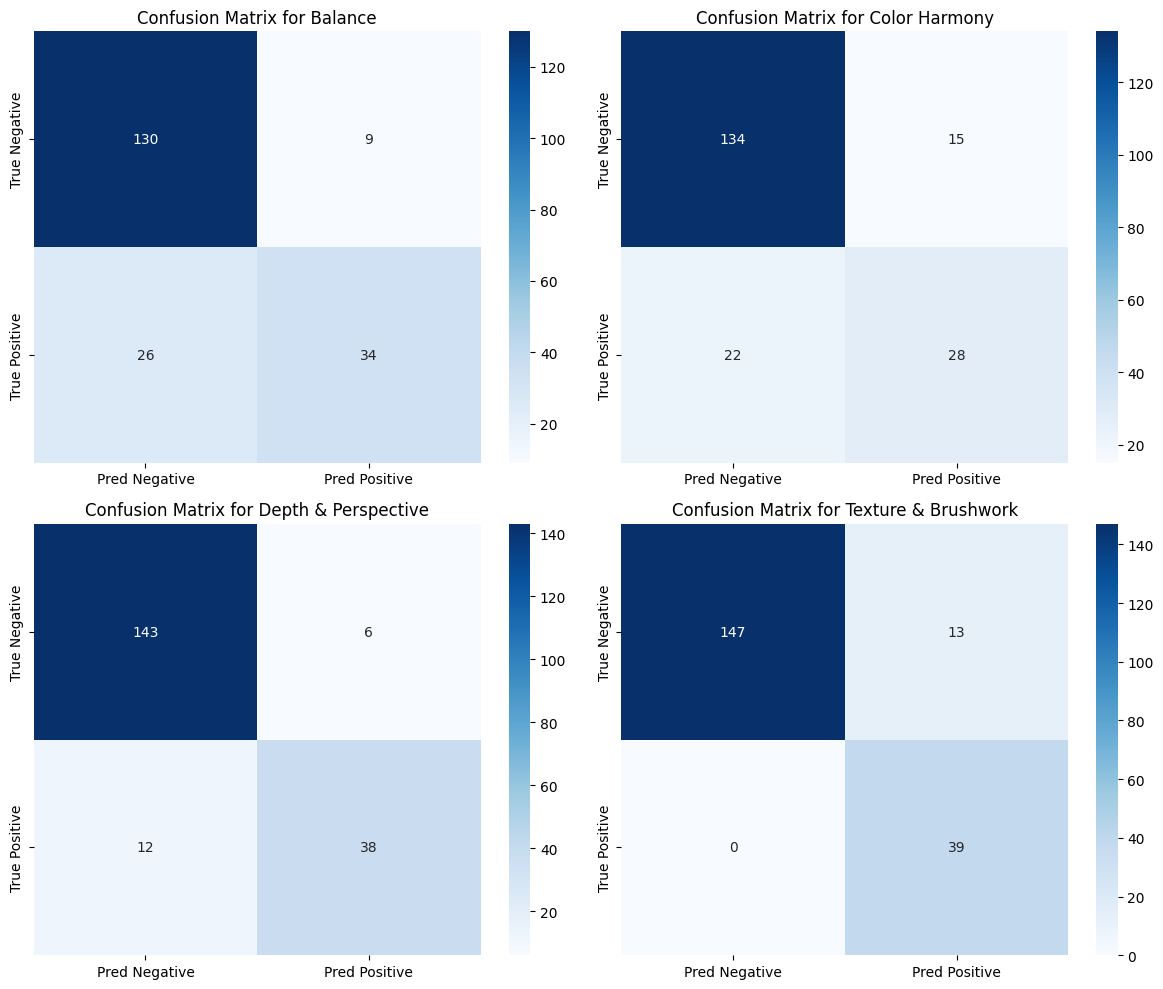

Test Accuracy: 87.06%
Precision: 69.85%
Recall: 69.85%
F1-Score: 69.85%


In [ ]:
# Define aesthetic categories
aesthetic_categories = ["Balance", "Color Harmony", "Depth & Perspective", "Texture & Brushwork"]

# Set the model to evaluation mode
efficientnet_model.eval()

# Initialize variables to hold predictions and ground truths
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        balance, color_harmony, depth_perspective, texture_brushwork = efficientnet_model(images)

        # Convert logits to probabilities using sigmoid
        predictions_balance = torch.sigmoid(balance)
        predictions_color_harmony = torch.sigmoid(color_harmony)
        predictions_depth_perspective = torch.sigmoid(depth_perspective)
        predictions_texture_brushwork = torch.sigmoid(texture_brushwork)

        # Binarize predictions (thresholding at 0.5)
        predicted_labels_balance = (predictions_balance > 0.5).float()
        predicted_labels_color_harmony = (predictions_color_harmony > 0.5).float()
        predicted_labels_depth_perspective = (predictions_depth_perspective > 0.5).float()
        predicted_labels_texture_brushwork = (predictions_texture_brushwork > 0.5).float()

        # Concatenate the predictions for all categories (multi-label classification)
        all_predictions.append(torch.cat((predicted_labels_balance, predicted_labels_color_harmony,
                                          predicted_labels_depth_perspective, predicted_labels_texture_brushwork), dim=1))
        all_labels.append(labels)

# Convert the lists to tensors
all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Calculate accuracy
accuracy = (all_predictions == all_labels).sum() / all_labels.size

# Calculate Precision, Recall, and F1-Score (using 'samples' average for multi-label)
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')

# Generate Multi-label Confusion Matrix (for each class)
mcm = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'], ax=ax)
    ax.set_title(f'Confusion Matrix for {aesthetic_categories[i]}')

plt.tight_layout()
plt.show()

# Display the evaluation metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
from tqdm import tqdm
from PIL import Image
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler

# Define model based on AlexNet with custom heads for the 4 aesthetic classes
class AestheticModelWithAlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(AestheticModelWithAlexNet, self).__init__()
        # Load pre-trained AlexNet model
        self.alexnet = models.alexnet(pretrained=True)

        # Get the input features from AlexNet's final fully connected layer
        in_features = self.alexnet.classifier[6].in_features
        self.alexnet.classifier[6] = nn.Identity()  # Remove the original head to add custom heads

        # Custom heads for each of the 4 aesthetic categories
        self.balance_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Balance class
        )

        self.color_harmony_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Color Harmony class
        )

        self.depth_perspective_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Depth & Perspective class
        )

        self.texture_brushwork_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Texture & Brushwork class
        )

    def forward(self, x):
        # Forward pass through AlexNet
        features = self.alexnet(x)

        # Get the output from each custom head
        balance = self.balance_head(features)
        color_harmony = self.color_harmony_head(features)
        depth_perspective = self.depth_perspective_head(features)
        texture_brushwork = self.texture_brushwork_head(features)

        return balance, color_harmony, depth_perspective, texture_brushwork


# Initialize model, loss function, and optimizer
alexnet_model = AestheticModelWithAlexNet(num_classes=4).to(device)
criterion = nn.BCEWithLogitsLoss()  # Suitable for multi-label classification

# Use AdamW optimizer for better regularization (weight decay) and improved performance
optimizer = optim.AdamW(alexnet_model.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler (reduce learning rate when validation loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Training loop with progress bar and time tracking
num_epochs = 25
start_time = time.time()  # Start time for total training

for epoch in range(num_epochs):
    alexnet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()  # Start time for this epoch

    # Initialize tqdm progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            balance, color_harmony, depth_perspective, texture_brushwork = alexnet_model(images)

            # Calculate loss for each output (balance, color harmony, etc.)
            loss_balance = criterion(balance.squeeze(), labels[:, 0])
            loss_color_harmony = criterion(color_harmony.squeeze(), labels[:, 1])
            loss_depth_perspective = criterion(depth_perspective.squeeze(), labels[:, 2])
            loss_texture_brushwork = criterion(texture_brushwork.squeeze(), labels[:, 3])

            # Total loss is the sum of all losses
            total_loss = loss_balance + loss_color_harmony + loss_depth_perspective + loss_texture_brushwork
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            # Update accuracy
            predictions = torch.cat([
                torch.sigmoid(balance),
                torch.sigmoid(color_harmony),
                torch.sigmoid(depth_perspective),
                torch.sigmoid(texture_brushwork)
            ], dim=1)

            # Binarize predictions (thresholding at 0.5)
            predicted_labels = (predictions > 0.5).float()

            # Compare predicted labels with the ground truth labels
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)  # Total labels for all 4 categories

            # Update the progress bar with loss information
            tepoch.set_postfix(loss=total_loss.item())

    epoch_end_time = time.time()  # End time for this epoch
    epoch_duration = epoch_end_time - epoch_start_time  # Duration of the epoch
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader)}")
    print(f"Train Accuracy: {correct_train / total_train:.2f}%")

    # Validation phase
    alexnet_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            balance, color_harmony, depth_perspective, texture_brushwork = alexnet_model(images)

            # Convert logits to probabilities (using sigmoid)
            predictions_balance = torch.sigmoid(balance)
            predictions_color_harmony = torch.sigmoid(color_harmony)
            predictions_depth_perspective = torch.sigmoid(depth_perspective)
            predictions_texture_brushwork = torch.sigmoid(texture_brushwork)

            # Compare predictions to actual labels
            predicted_labels_balance = (predictions_balance > 0.5).float()
            predicted_labels_color_harmony = (predictions_color_harmony > 0.5).float()
            predicted_labels_depth_perspective = (predictions_depth_perspective > 0.5).float()
            predicted_labels_texture_brushwork = (predictions_texture_brushwork > 0.5).float()

            correct_val += (predicted_labels_balance == labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_color_harmony == labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_depth_perspective == labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_texture_brushwork == labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4  # Total labels for all 4 categories

    val_accuracy = correct_val / total_val
    print(f"Epoch {epoch+1}/{num_epochs} Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Step the learning rate scheduler
    scheduler.step(running_loss)

# Total time for training
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({(total_training_time / 60):.2f} minutes)")

# Test Accuracy Evaluation
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        balance, color_harmony, depth_perspective, texture_brushwork = alexnet_model(images)

        # Convert logits to probabilities
        predictions = torch.cat([
            torch.sigmoid(balance),
            torch.sigmoid(color_harmony),
            torch.sigmoid(depth_perspective),
            torch.sigmoid(texture_brushwork)
        ], dim=1)

        # Binarize predictions (threshold = 0.5)
        predicted_labels = (predictions > 0.5).float()

        # Compute accuracy
        correct_test += (predicted_labels == labels).sum().item()
        total_test += labels.numel()

# Compute final test accuracy
test_accuracy = correct_test / total_test * 100

# Display results
print(f"Test Accuracy: {test_accuracy:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 132MB/s]
Epoch 1/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.59batch/s, loss=1.45]


Epoch 1/25 completed in 23.90 seconds.
Epoch Loss: 1.654602789109753
Train Accuracy: 0.81%


Epoch 1/25 Validation Accuracy: 77.91%


Epoch 2/25 Training: 100%|██████████| 62/62 [00:24<00:00,  2.54batch/s, loss=1.28]


Epoch 2/25 completed in 24.45 seconds.
Epoch Loss: 0.912772056556517
Train Accuracy: 0.91%


Epoch 2/25 Validation Accuracy: 80.03%


Epoch 3/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.59batch/s, loss=0.222]


Epoch 3/25 completed in 23.95 seconds.
Epoch Loss: 0.5187990583719746
Train Accuracy: 0.95%


Epoch 3/25 Validation Accuracy: 83.60%


Epoch 4/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.61batch/s, loss=0.256]


Epoch 4/25 completed in 23.71 seconds.
Epoch Loss: 0.21617062299722625
Train Accuracy: 0.98%


Epoch 4/25 Validation Accuracy: 84.39%


Epoch 5/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.62batch/s, loss=0.181]


Epoch 5/25 completed in 23.66 seconds.
Epoch Loss: 0.1943172152124105
Train Accuracy: 0.98%


Epoch 5/25 Validation Accuracy: 84.52%


Epoch 6/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.62batch/s, loss=0.0413]


Epoch 6/25 completed in 23.63 seconds.
Epoch Loss: 0.1043814403125115
Train Accuracy: 0.99%


Epoch 6/25 Validation Accuracy: 84.13%


Epoch 7/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.60batch/s, loss=0.0562]


Epoch 7/25 completed in 23.86 seconds.
Epoch Loss: 0.07149060946258326
Train Accuracy: 0.99%


Epoch 7/25 Validation Accuracy: 83.73%


Epoch 8/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.63batch/s, loss=0.0225]


Epoch 8/25 completed in 23.60 seconds.
Epoch Loss: 0.03697040796114673
Train Accuracy: 1.00%


Epoch 8/25 Validation Accuracy: 84.52%


Epoch 9/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.61batch/s, loss=0.0308]


Epoch 9/25 completed in 23.78 seconds.
Epoch Loss: 0.07160242055655427
Train Accuracy: 0.99%


Epoch 9/25 Validation Accuracy: 83.60%


Epoch 10/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.59batch/s, loss=0.0427]


Epoch 10/25 completed in 23.91 seconds.
Epoch Loss: 0.09220752225167328
Train Accuracy: 0.99%


Epoch 10/25 Validation Accuracy: 83.47%


Epoch 11/25 Training: 100%|██████████| 62/62 [00:24<00:00,  2.54batch/s, loss=0.00367]


Epoch 11/25 completed in 24.45 seconds.
Epoch Loss: 0.04298374870596754
Train Accuracy: 1.00%


Epoch 11/25 Validation Accuracy: 83.60%


Epoch 12/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.60batch/s, loss=0.113]


Epoch 12/25 completed in 23.82 seconds.
Epoch Loss: 0.14533806196789467
Train Accuracy: 0.99%


Epoch 12/25 Validation Accuracy: 85.45%


Epoch 13/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.62batch/s, loss=0.0302]


Epoch 13/25 completed in 23.64 seconds.
Epoch Loss: 0.026186219796786207
Train Accuracy: 1.00%


Epoch 13/25 Validation Accuracy: 86.24%


Epoch 14/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.60batch/s, loss=0.001]


Epoch 14/25 completed in 23.83 seconds.
Epoch Loss: 0.006573615136608902
Train Accuracy: 1.00%


Epoch 14/25 Validation Accuracy: 86.38%


Epoch 15/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.64batch/s, loss=0.0023]


Epoch 15/25 completed in 23.48 seconds.
Epoch Loss: 0.004056608032119731
Train Accuracy: 1.00%


Epoch 15/25 Validation Accuracy: 86.64%


Epoch 16/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.61batch/s, loss=0.000723]


Epoch 16/25 completed in 23.80 seconds.
Epoch Loss: 0.0023840807951919195
Train Accuracy: 1.00%


Epoch 16/25 Validation Accuracy: 85.85%


Epoch 17/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.60batch/s, loss=0.00114]


Epoch 17/25 completed in 23.83 seconds.
Epoch Loss: 0.001869197313827763
Train Accuracy: 1.00%


Epoch 17/25 Validation Accuracy: 86.11%


Epoch 18/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.60batch/s, loss=0.000291]


Epoch 18/25 completed in 23.86 seconds.
Epoch Loss: 0.0011912846903508198
Train Accuracy: 1.00%


Epoch 18/25 Validation Accuracy: 85.98%


Epoch 19/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.60batch/s, loss=0.000155]


Epoch 19/25 completed in 23.90 seconds.
Epoch Loss: 0.0008427137300097984
Train Accuracy: 1.00%


Epoch 19/25 Validation Accuracy: 86.11%


Epoch 20/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.59batch/s, loss=0.000152]


Epoch 20/25 completed in 23.95 seconds.
Epoch Loss: 0.0006117160670739043
Train Accuracy: 1.00%


Epoch 20/25 Validation Accuracy: 86.38%


Epoch 21/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.60batch/s, loss=0.000633]


Epoch 21/25 completed in 23.83 seconds.
Epoch Loss: 0.0006507291248659209
Train Accuracy: 1.00%


Epoch 21/25 Validation Accuracy: 85.71%


Epoch 22/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.60batch/s, loss=9.84e-5]


Epoch 22/25 completed in 23.81 seconds.
Epoch Loss: 0.0006137297649758928
Train Accuracy: 1.00%


Epoch 22/25 Validation Accuracy: 85.98%


Epoch 23/25 Training: 100%|██████████| 62/62 [00:24<00:00,  2.51batch/s, loss=0.00029]


Epoch 23/25 completed in 24.69 seconds.
Epoch Loss: 0.0008374667452317813
Train Accuracy: 1.00%


Epoch 23/25 Validation Accuracy: 85.58%


Epoch 24/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.60batch/s, loss=4.03e-5]


Epoch 24/25 completed in 23.83 seconds.
Epoch Loss: 0.0005031074413402107
Train Accuracy: 1.00%


Epoch 24/25 Validation Accuracy: 85.71%


Epoch 25/25 Training: 100%|██████████| 62/62 [00:23<00:00,  2.60batch/s, loss=0.000164]


Epoch 25/25 completed in 23.82 seconds.
Epoch Loss: 0.0003278996333509924
Train Accuracy: 1.00%


Epoch 25/25 Validation Accuracy: 86.38%

Total Training Time: 656.81 seconds (10.95 minutes)
Test Accuracy: 87.44%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


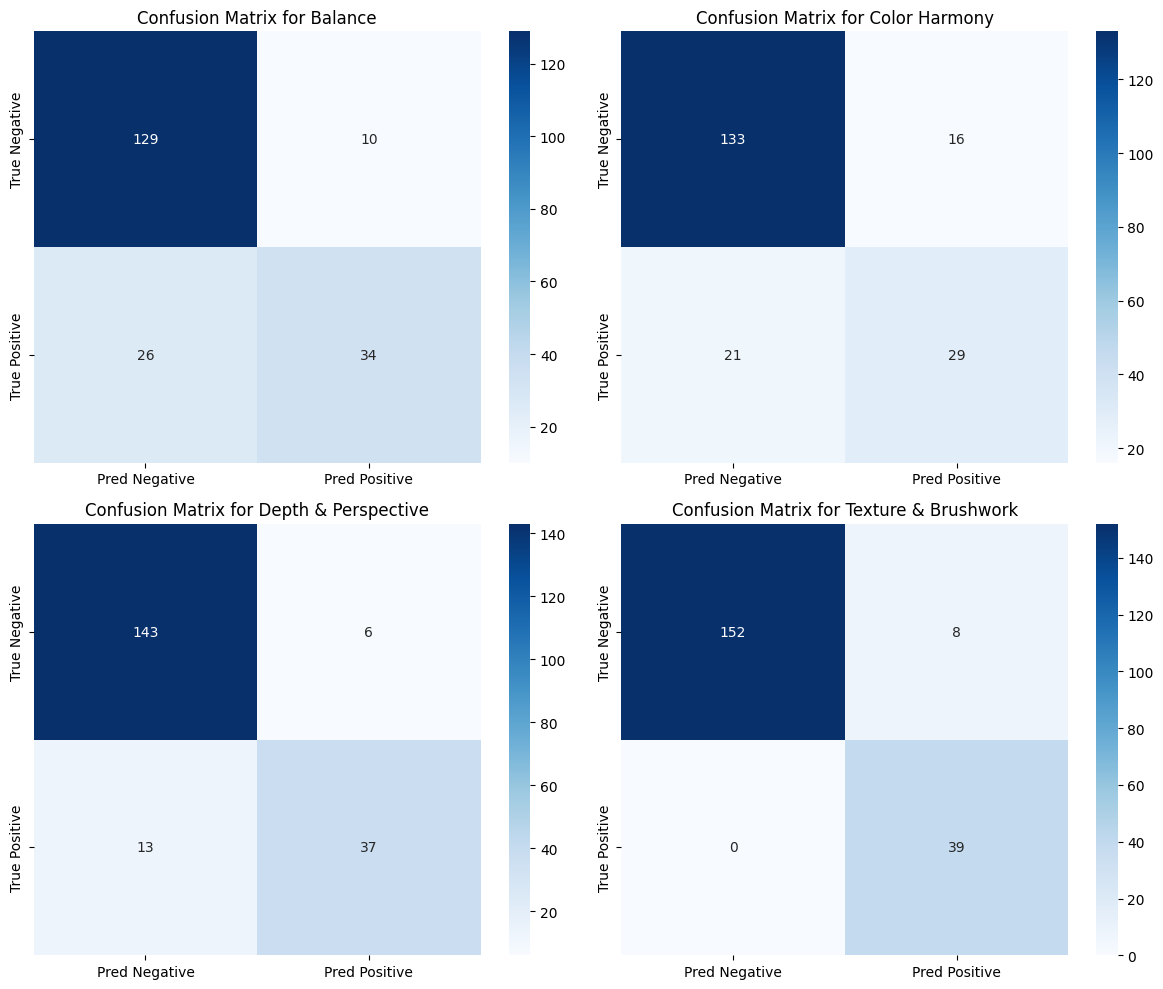

Test Accuracy: 87.44%
Precision: 69.85%
Recall: 69.85%
F1-Score: 69.85%


In [ ]:
# Define aesthetic categories
aesthetic_categories = ["Balance", "Color Harmony", "Depth & Perspective", "Texture & Brushwork"]

# Set the model to evaluation mode
alexnet_model.eval()

# Initialize variables to hold predictions and ground truths
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        balance, color_harmony, depth_perspective, texture_brushwork = alexnet_model(images)

        # Convert logits to probabilities using sigmoid
        predictions_balance = torch.sigmoid(balance)
        predictions_color_harmony = torch.sigmoid(color_harmony)
        predictions_depth_perspective = torch.sigmoid(depth_perspective)
        predictions_texture_brushwork = torch.sigmoid(texture_brushwork)

        # Binarize predictions (thresholding at 0.5)
        predicted_labels_balance = (predictions_balance > 0.5).float()
        predicted_labels_color_harmony = (predictions_color_harmony > 0.5).float()
        predicted_labels_depth_perspective = (predictions_depth_perspective > 0.5).float()
        predicted_labels_texture_brushwork = (predictions_texture_brushwork > 0.5).float()

        # Concatenate the predictions for all categories (multi-label classification)
        all_predictions.append(torch.cat((predicted_labels_balance, predicted_labels_color_harmony,
                                          predicted_labels_depth_perspective, predicted_labels_texture_brushwork), dim=1))
        all_labels.append(labels)

# Convert the lists to tensors
all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Calculate accuracy
accuracy = (all_predictions == all_labels).sum() / all_labels.size

# Calculate Precision, Recall, and F1-Score (using 'samples' average for multi-label)
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')

# Generate Multi-label Confusion Matrix (for each class)
mcm = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'], ax=ax)
    ax.set_title(f'Confusion Matrix for {aesthetic_categories[i]}')

plt.tight_layout()
plt.show()

# Display the evaluation metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

